# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (lrti).

In [119]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [120]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [121]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [122]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [123]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [124]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_lrti_admitted', 'duration_lrti_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [125]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [126]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [127]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [128]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [129]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [130]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [131]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [132]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [133]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [134]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [135]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [136]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

data.shape

(200000, 224)

In [137]:
# # save model outputs
# a = open("../output/hospitalisation_prediction_lrti/data_lrti_record_cph_lrti.txt", "w")
# a.write("")
# a.writelines(['data_lrti_1 #with a record, #with no record: %.0f' % (data['lrti_date_1'].notna().sum()), ', %.0f' % (data['lrti_date_1'].isna().sum()),
#               '\ndata_lrti_2 #with a record, #with no record: %.0f' % (data['lrti_date_2'].notna().sum()), ', %.0f' % (data['lrti_date_2'].isna().sum()),
#               '\ndata_lrti_3 #with a record, #with no record: %.0f' % (data['lrti_date_3'].notna().sum()), ', %.0f' % (data['lrti_date_3'].isna().sum()),
#               '\ndata_lrti_4 #with a record, #with no record: %.0f' % (data['lrti_date_4'].notna().sum()), ', %.0f' % (data['lrti_date_4'].isna().sum()),
#               '\ndata_lrti_5 #with a record, #with no record: %.0f' % (data['lrti_date_5'].notna().sum()), ', %.0f' % (data['lrti_date_5'].isna().sum()),
#               '\ndata_lrti_6 #with a record, #with no record: %.0f' % (data['lrti_date_6'].notna().sum()), ', %.0f' % (data['lrti_date_6'].isna().sum()),
#               '\ndata_lrti_7 #with a record, #with no record: %.0f' % (data['lrti_date_7'].notna().sum()), ', %.0f' % (data['lrti_date_7'].isna().sum()),
#               '\ndata_lrti_8 #with a record, #with no record: %.0f' % (data['lrti_date_8'].notna().sum()), ', %.0f' % (data['lrti_date_8'].isna().sum()),
#               '\ndata_lrti_9 #with a record, #with no record: %.0f' % (data['lrti_date_9'].notna().sum()), ', %.0f' % (data['lrti_date_9'].isna().sum()),
#               '\ndata_lrti_10 #with a record, #with no record: %.0f' % (data['lrti_date_10'].notna().sum()), ', %.0f' % (data['lrti_date_10'].isna().sum()),
#               '\ndata_lrti_11 #with a record, #with no record: %.0f' % (data['lrti_date_11'].notna().sum()), ', %.0f' % (data['lrti_date_11'].isna().sum()),
#               '\ndata_lrti_12 #with a record, #with no record: %.0f' % (data['lrti_date_12'].notna().sum()), ', %.0f' % (data['lrti_date_12'].isna().sum()),
#               '\ndata_lrti_13 #with a record, #with no record: %.0f' % (data['lrti_date_13'].notna().sum()), ', %.0f' % (data['lrti_date_13'].isna().sum()),
#               '\ndata_lrti_14 #with a record, #with no record: %.0f' % (data['lrti_date_14'].notna().sum()), ', %.0f' % (data['lrti_date_14'].isna().sum()),
#               '\ndata_lrti_15 #with a record, #with no record: %.0f' % (data['lrti_date_15'].notna().sum()), ', %.0f' % (data['lrti_date_15'].isna().sum()),
#               '\ndata_lrti_16 #with a record, #with no record: %.0f' % (data['lrti_date_16'].notna().sum()), ', %.0f' % (data['lrti_date_16'].isna().sum()),
#               '\ndata_lrti_17 #with a record, #with no record: %.0f' % (data['lrti_date_17'].notna().sum()), ', %.0f' % (data['lrti_date_17'].isna().sum()),
#               '\ndata_lrti_18 #with a record, #with no record: %.0f' % (data['lrti_date_18'].notna().sum()), ', %.0f' % (data['lrti_date_18'].isna().sum()),
#               '\ndata_lrti_19 #with a record, #with no record: %.0f' % (data['lrti_date_19'].notna().sum()), ', %.0f' % (data['lrti_date_19'].isna().sum()),
#               '\ndata_lrti_20 #with a record, #with no record: %.0f' % (data['lrti_date_20'].notna().sum()), ', %.0f' % (data['lrti_date_20'].isna().sum()),
#               ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [138]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37229
1.0     36723
2.0     33050
3.0     24897
4.0     15102
6.0     12227
7.0      9811
5.0      8259
8.0      8132
9.0      5817
10.0     3323
11.0     1953
12.0     1322
13.0      848
14.0      558
15.0      369
16.0      202
17.0       91
18.0       60
19.0       15
20.0        9
21.0        3
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [139]:
#read 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)
data_lrti.shape

(360037, 20)

### 2-2- add season, event, and duration variables
#### season

In [140]:
# convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] #gp_cons_lrti
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')
print(f'min date: {data_lrti.date.min()}')
print(f'max date: {data_lrti.date.max()}')
print(f'length of data_lrti: {len(data_lrti)}')

min date: 2019-01
max date: 2022-11
length of data_lrti: 360037


In [141]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

print(data_lrti['season'].value_counts())
print(f'\nmin date: {data_lrti.date.min()}')
print(f'max date: {data_lrti.date.max()}')
print(f'length: {len(data_lrti)}')

summer    93737
spring    93417
winter    83688
autumn    69436
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 340278


In [142]:
# data_lrti = data_lrti[data_lrti['date'] <= '2019-12']
# data_lrti = data_lrti[(data_lrti['date'] >= '2020-03') & (data_lrti['date']<= '2021-03')]
# data_lrti = data_lrti[data_lrti['date'] >= '2021-04']
# print(f'min date: {data_lrti.date.min()}')
# print(f'max date: {data_lrti.date.max()}')

In [143]:
#add period variable
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [144]:
#scenario 1
#not hosped (nothing happened)
#data_lrti = data_lrti[data_lrti['admitted_lrti_date'].notnull()]
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0
data_lrti['event_lrti_admitted'].value_counts()

0.0    237937
Name: event_lrti_admitted, dtype: int64

In [145]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days #gp_cons_lrti
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1
# data_lrti['event_lrti_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]
data_lrti['delta_lrti_admitted'].value_counts()

138.0     94
85.0      94
19.0      90
161.0     89
17.0      87
          ..
1351.0     1
1406.0     1
1358.0     1
1376.0     1
1382.0     1
Name: delta_lrti_admitted, Length: 1396, dtype: int64

In [146]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_lrti.loc[data_lrti['delta_admitted_died'] >= 0, 'event_lrti_admitted'] = 0
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0
# data_lrti['event_lrti_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_lrti.loc[data_lrti['delta_admitted_deregistered'] >= 0, 'event_lrti_admitted'] = 0
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0
# data_lrti['event_lrti_admitted'].value_counts()

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_lrti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

286689

In [147]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)
data_lrti['event_lrti_admitted'].value_counts()

0.0    289810
1.0      2216
Name: event_lrti_admitted, dtype: int64

In [148]:
#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30
data_lrti['duration_lrti_admitted'].value_counts()

30.0    289887
19.0        90
17.0        87
10.0        86
13.0        85
0.0         83
4.0         79
12.0        79
22.0        79
20.0        78
11.0        78
23.0        76
9.0         74
28.0        73
5.0         73
25.0        73
7.0         72
3.0         72
14.0        69
8.0         69
6.0         68
16.0        66
2.0         66
1.0         66
29.0        60
27.0        60
15.0        60
26.0        59
24.0        59
18.0        52
21.0        48
Name: duration_lrti_admitted, dtype: int64

In [149]:
# give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1
data_lrti['event_lrti_admitted'].value_counts()

0.0    289807
1.0      2219
Name: event_lrti_admitted, dtype: int64

In [150]:
#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

In [151]:
# data_lrti[data_lrti['duration_lrti_admitted']==0][['delta_lrti_admitted', 'lrti_date', 'gp_cons_lrti', 'admitted_lrti_date', 'delta_lrti_admitted', 'delta_admitted_died_deregistered', 'event_lrti_admitted', 'duration_lrti_admitted']]
# data_lrti.loc[151:200, ['event_lrti_admitted', 'duration_lrti_admitted']]
# data_lrti.loc[201:250, ['event_lrti_admitted', 'duration_lrti_admitted']].sort_values(by=['duration_lrti_admitted'])
data_lrti[['event_lrti_admitted', 'duration_lrti_admitted']].sort_values(by=['duration_lrti_admitted'])

,event_lrti_admitted,duration_lrti_admitted
316193,1.0,1.0
29879,1.0,1.0
47072,1.0,1.0
157211,1.0,1.0
191104,1.0,1.0
...,...,...
120230,0.0,30.0
120229,0.0,30.0
120228,0.0,30.0
120234,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [152]:
# prep before plot
data_lrti['age'][data_lrti['age'] < 0] = np.nan
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14']
# drop anybody with age less than 18
data_lrti = data_lrti[~(data_lrti['age'] < 18)]  
print(f'Min age: {data_lrti.age.min()}')

## remove died cases
#data_lrti.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
# replace 0s with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [153]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})

In [154]:
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_lrti['region_imp'] = data_lrti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_lrti.region.isnull().sum()}')
    data_lrti = data_lrti[data_lrti['region'].notna()]

print(f'Cound of missing values in variable region: {data_lrti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_lrti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35315
East                        18027
South East                  17892
North West                  17863
West Midlands               17694
Yorkshire and The Humber    17689
East Midlands               17586
South West                  17547
North East                  17532
Name: region, dtype: int64


In [155]:
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_lrti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_lrti.antibacterial_brit.mean():.3f}')
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)
    # data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_lrti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_lrti.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 2
Mean of antibacterial_brit values before changing NAN to zeros: 1.252

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.252


In [156]:
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_lrti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_lrti.ethnicity.value_counts()}')
    # data_lrti['ethnicity'] = data_lrti['ethnicity'].astype(str)
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_lrti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_lrti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 44248
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    106440
5.0     13231
3.0     13226
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    106440
0.0     44248
5.0     13231
3.0     13226
Name: ethnicity, dtype: int64


In [157]:
if ('smoking_status' in data_lrti.columns) and (data_lrti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_lrti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_lrti.smoking_status.value_counts()}')
    # data_lrti['smoking_status'] = data_lrti['smoking_status'].astype(str)
    data_lrti['smoking_status'] = data_lrti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_lrti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_lrti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73328
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    69553
3.0    23084
2.0    11180
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73328
1.0    69553
3.0    23084
2.0    11180
Name: smoking_status, dtype: int64


In [158]:
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_lrti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_lrti.imd.value_counts()}')
    # data_lrti['imd'] = data_lrti['imd'].astype(str)
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_lrti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_lrti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
1    33794
5    33766
4    33659
2    33549
3    33395
0     8982
Name: imd, dtype: int64


In [159]:
data_lrti['bmi_cat'] = 5
col_bmi_cat = data_lrti.columns.get_loc('bmi_cat')

col_sex = data_lrti.columns.get_loc('sex')
col_age = data_lrti.columns.get_loc('age')
col_bmi = data_lrti.columns.get_loc('bmi')

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, col_bmi] >= 30:
        data_lrti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_lrti.iat[idx, col_bmi] >= 25) and (data_lrti.iat[idx, col_bmi] < 30):
        data_lrti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_lrti.iat[idx, col_bmi] >= 18.5) and (data_lrti.iat[idx, col_bmi] < 25):
        data_lrti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_lrti.iat[idx, col_bmi] < 18.5:
        data_lrti.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_lrti['bmi_cat'].value_counts()

1    91805
5    45162
2    19733
3    14742
4     5703
Name: bmi_cat, dtype: int64

In [160]:
if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_lrti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_lrti.bmi_cat.value_counts()}')
    # data_lrti['bmi_cat'] = data_lrti['bmi_cat'].astype(str)
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_lrti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_lrti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    91805
5    45162
2    19733
3    14742
4     5703
Name: bmi_cat, dtype: int64


In [161]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])

#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)
data_lrti['ab_type_cat'].value_counts()

no             159273
0               14301
other            2177
Amoxicillin      1025
Doxycycline       369
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [162]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [163]:
# reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})
data_lrti['ab_type_cat'].value_counts()

no             159273
other           16478
Amoxicillin      1025
Doxycycline       369
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [164]:
# categorising
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_lrti['CCI_cat'].value_counts()

low          61878
medium       35699
very_low     32817
very_high    28797
high         17954
Name: CCI_cat, dtype: int64

In [165]:
# assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)
data_lrti['antibacterial_brit'].max()

data_lrti['antibacterial_brit_cat'] = pd.cut(data_lrti['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_lrti['antibacterial_brit_cat'].value_counts()

low       102673
high       44384
medium     30088
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

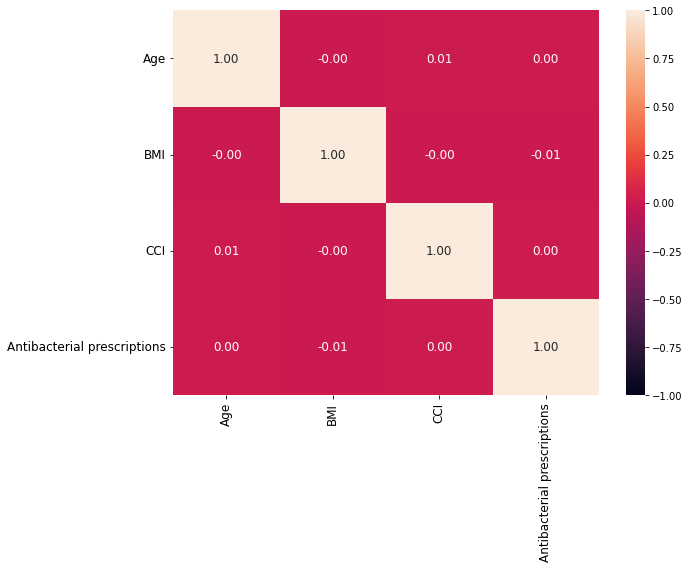

In [166]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

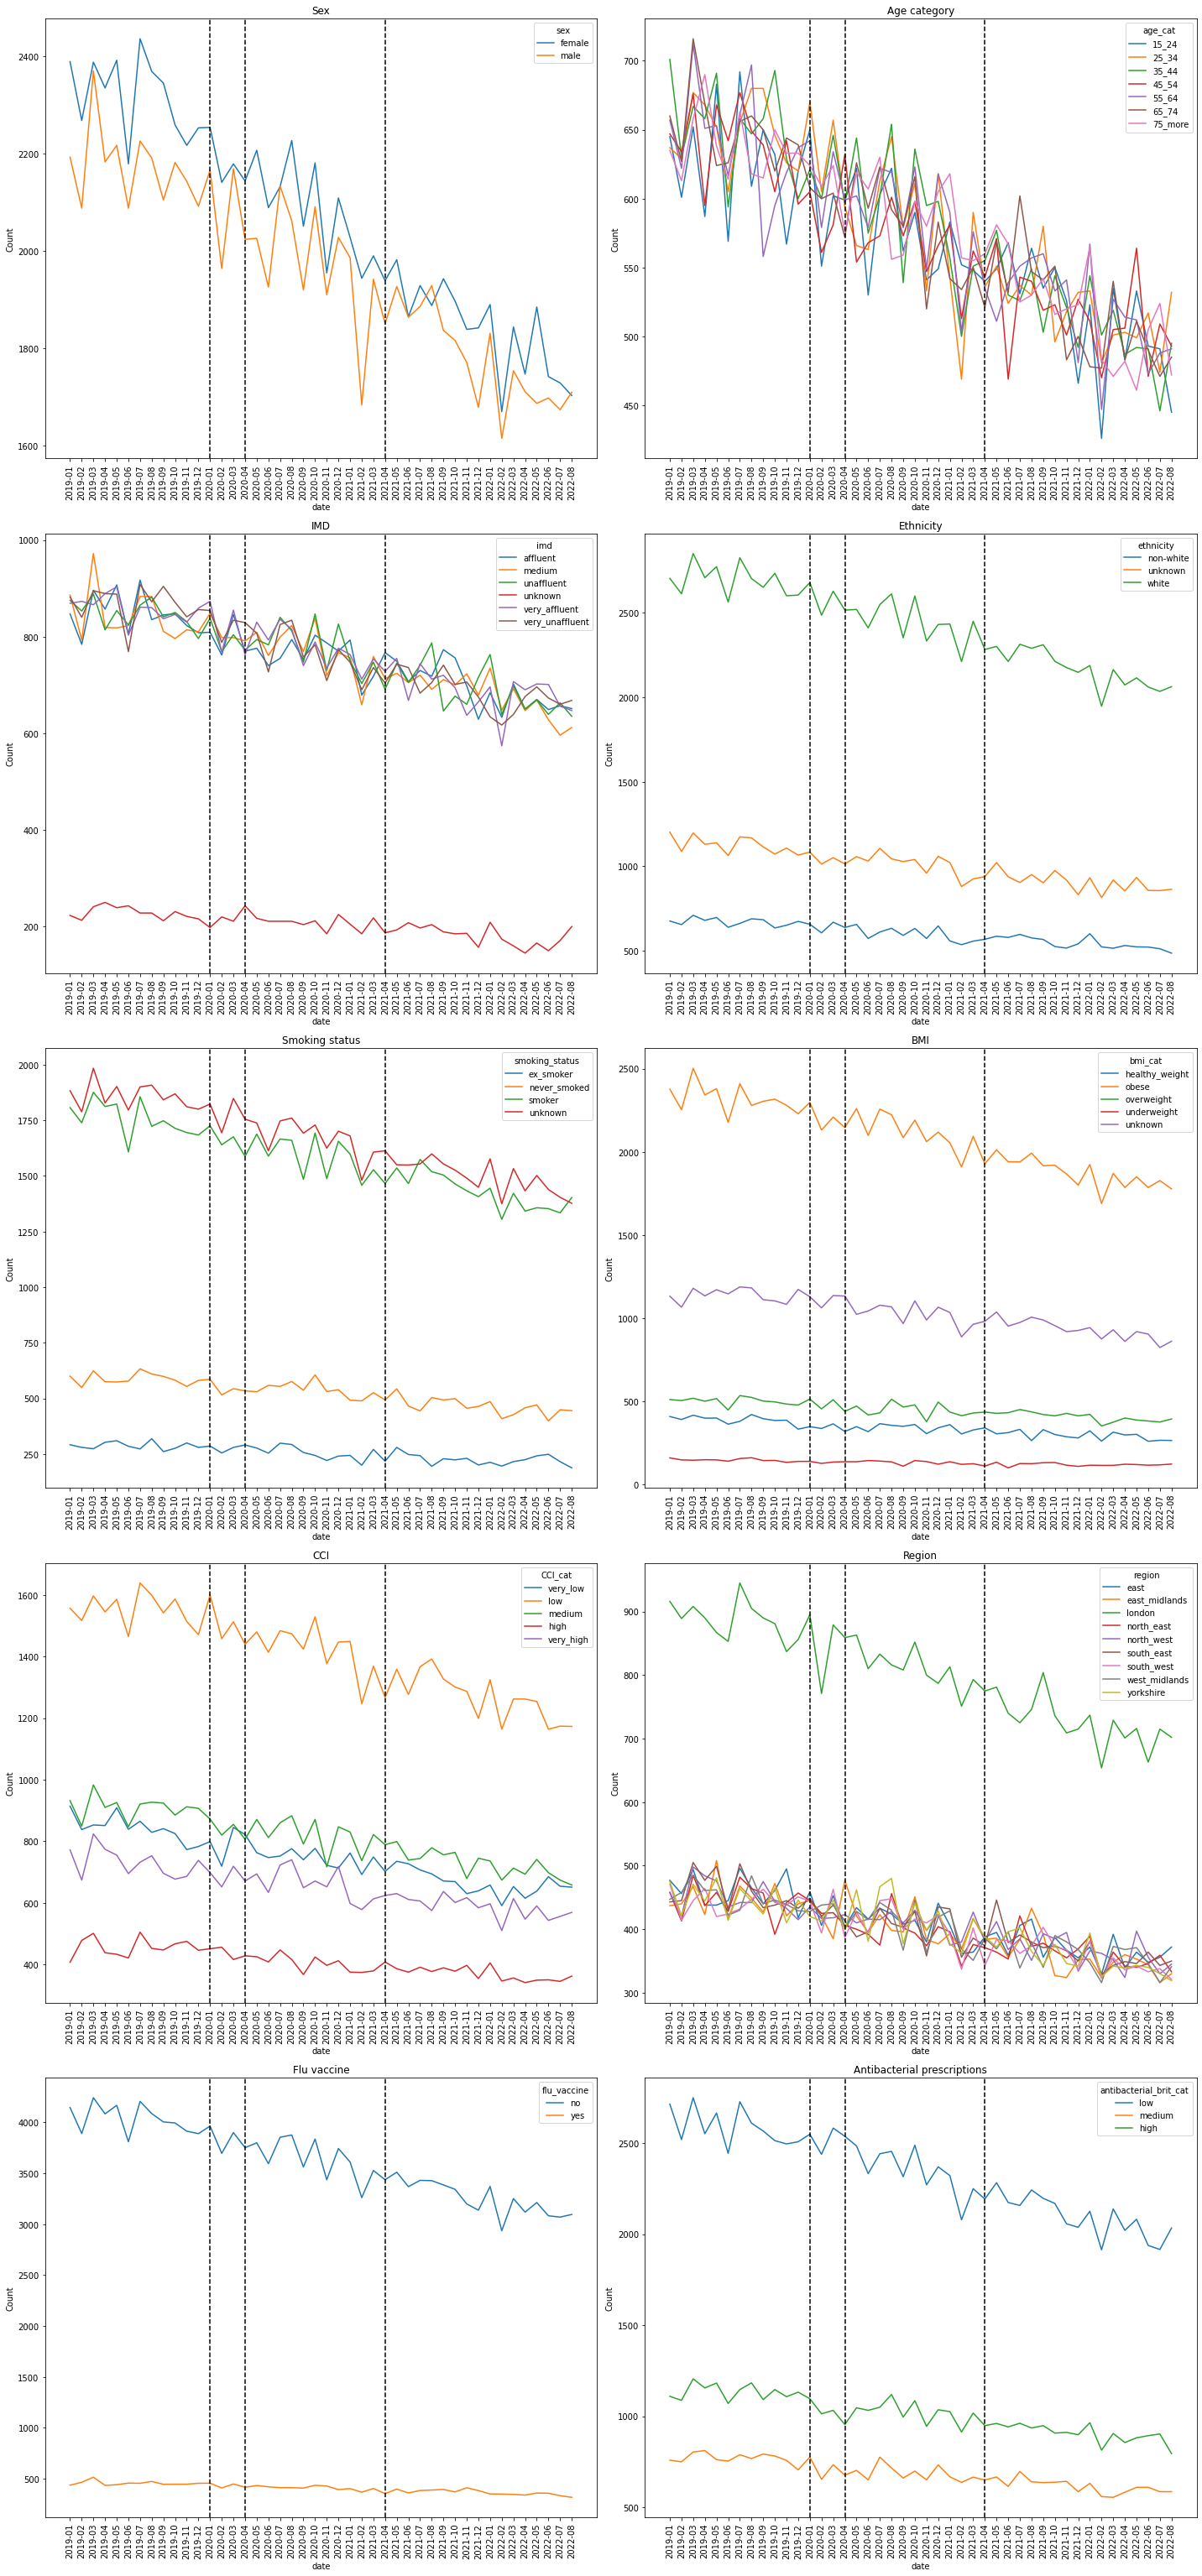

In [167]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_lrti, 'sex', 'Sex', axes[0,0])
create_lineplot(data_lrti, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_lrti, 'imd', 'IMD', axes[1,0])
create_lineplot(data_lrti, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_lrti, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_lrti, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_lrti, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_lrti, 'region', 'Region', axes[3,1])
create_lineplot(data_lrti, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_lrti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of lrti patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/risk_factors_cat_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of lrti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [168]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                       'event_lrti_admitted', 'duration_lrti_admitted'
                        ]]

data_lrti.shape

(177145, 18)

In [169]:
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]
#switch variable lrti_ab_date into a binary variable
data_lrti_incdt[['lrti_ab_date']] = data_lrti_incdt[['lrti_ab_date']].where(data_lrti_incdt[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_lrti_prevl[['lrti_ab_date']] = data_lrti_prevl[['lrti_ab_date']].where(data_lrti_prevl[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_lrti_incdt_males = data_lrti_incdt[data_lrti_incdt['sex'] == 'male']
data_lrti_incdt_females = data_lrti_incdt[data_lrti_incdt['sex'] == 'female']
data_lrti_prevl_males = data_lrti_prevl[data_lrti_prevl['sex'] == 'male']
data_lrti_prevl_females = data_lrti_prevl[data_lrti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_lrti_incdt_15_24 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '15_24']
data_lrti_incdt_25_34 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '25_34']
data_lrti_incdt_35_44 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '35_44']
data_lrti_incdt_45_54 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '45_54']
data_lrti_incdt_55_64 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '55_64']
data_lrti_incdt_65_74 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '65_74']
data_lrti_incdt_75_more = data_lrti_incdt[data_lrti_incdt['age_cat'] == '75_more']
data_lrti_prevl_15_24 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '15_24']
data_lrti_prevl_25_34 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '25_34']
data_lrti_prevl_35_44 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '35_44']
data_lrti_prevl_45_54 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '45_54']
data_lrti_prevl_55_64 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '55_64']
data_lrti_prevl_65_74 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '65_74']
data_lrti_prevl_75_more = data_lrti_prevl[data_lrti_prevl['age_cat'] == '75_more']

data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['date'] <= '2019-12']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['date'] >= '2020-03') & (data_lrti_incdt['date']<= '2021-03')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['date'] <= '2021-04']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['date'] <= '2019-12']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['date'] >= '2020-03') & (data_lrti_prevl['date']<= '2021-03')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_lrti_incdt_abtype_0 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[0]]
# data_lrti_incdt_abtype_1 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[1]]
# data_lrti_incdt_abtype_2 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[2]]
# data_lrti_incdt_abtype_3 = data_lrti_incdt[data_lrti_incdt['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[3]]
# data_lrti_prevl_abtype_0 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[0]]
# data_lrti_prevl_abtype_1 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[1]]
# data_lrti_prevl_abtype_2 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[2]]
# data_lrti_prevl_abtype_3 = data_lrti_prevl[data_lrti_prevl['ab_type_cat'] == data_lrti['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_lrti_incdt_abs = data_lrti_incdt[data_lrti_incdt['lrti_ab_date'] == 1]
# data_lrti_prevl_abs = data_lrti_prevl[data_lrti_prevl['lrti_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()] #gp_cons_lrti_ab
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]

# with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

print(f'shape of data_lrti_incdt: {data_lrti_incdt.shape}')
print(f'shape of data_lrti_prevl: {data_lrti_prevl.shape}')
print(f'shape of data_lrti_no_abs_incdt: {data_lrti_no_abs_incdt.shape}')
print(f'shape of data_lrti_abs_incdt: {data_lrti_abs_incdt.shape}')
print(f'shape of data_lrti_no_abs_prevl: {data_lrti_no_abs_prevl.shape}')
print(f'shape of data_lrti_abs_prevl: {data_lrti_abs_prevl.shape}')
print(f'\nvalue counts of data_lrti_no_abs_incdt: \n{data_lrti_no_abs_incdt.event_lrti_admitted.value_counts()}')
print(f'value counts of data_lrti_abs_incdt: \n{data_lrti_abs_incdt.event_lrti_admitted.value_counts()}')
print(f'value counts of data_lrti_no_abs_prevl: \n{data_lrti_no_abs_prevl.event_lrti_admitted.value_counts()}')
print(f'value counts of data_lrti_abs_prevl: \n{data_lrti_abs_prevl.event_lrti_admitted.value_counts()}')

shape of data_lrti_incdt: (159382, 18)
shape of data_lrti_prevl: (17763, 18)
shape of data_lrti_no_abs_incdt: (143235, 18)
shape of data_lrti_abs_incdt: (16147, 18)
shape of data_lrti_no_abs_prevl: (16038, 18)
shape of data_lrti_abs_prevl: (1725, 18)

value counts of data_lrti_no_abs_incdt: 
0.0    142188
1.0      1047
Name: event_lrti_admitted, dtype: int64
value counts of data_lrti_abs_incdt: 
0.0    16034
1.0      113
Name: event_lrti_admitted, dtype: int64
value counts of data_lrti_no_abs_prevl: 
0.0    15934
1.0      104
Name: event_lrti_admitted, dtype: int64
value counts of data_lrti_abs_prevl: 
0.0    1715
1.0      10
Name: event_lrti_admitted, dtype: int64


In [170]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 107426 total observations, 106647 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 107426
number of events observed = 779
   partial log-likelihood = -9008.41
         time fit was run = 2022-11-22 12:41:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.11       0.11            -0.11             0.31                 0.90                 1.36
CCI_cat[T.medium]                0.11       1.12       0.12            -0.12             0.34                 0.89                 1.41
CCI_cat[T.high]                  0.17       1.18       0.14            -0.10             0.44                 0.90                 1.55
CCI_cat[T.very_high]             0.02       1.02       0.13            -0.23             0.27                 0.80                 1.31
age_cat[T.25_34]                 0.08       1.08       0.14            -0.19             0.35                 0.83                 1.41
age_cat[T.35_44]                 0.13       1.13       0.13            -0.14             0.39                 0.87                 1.48
age_cat[T.45_54]                 0.04       1.04       0.14            -0.23             0.31                 0.80                 1.36
age_cat[T.55_64]                -0.06       0.94       0.14            -0.33             0.22                 0.72                 1.24
age_cat[T.65_74]                 0.16       1.17       0.13            -0.10             0.42                 0.90                 1.52
age_cat[T.75_more]               0.06       1.06       0.14            -0.21             0.33                 0.81                 1.39
antibacterial_brit              -0.02       0.98       0.03            -0.07             0.03                 0.93                 1.03
bmi_cat[T.obese]                 0.02       1.02       0.14            -0.24             0.29                 0.78                 1.34
bmi_cat[T.overweight]            0.07       1.07       0.17            -0.25             0.39                 0.78                 1.48
bmi_cat[T.underweight]           0.33       1.39       0.21            -0.09             0.75                 0.91                 2.11
bmi_cat[T.unknown]              -0.02       0.98       0.15            -0.31             0.27                 0.74                 1.31
ethnicity[T.unknown]            -0.01       0.99       0.12            -0.24             0.22                 0.79                 1.25
ethnicity[T.white]              -0.01       0.99       0.10            -0.22             0.19                 0.81                 1.21
flu_vaccine[T.yes]              -0.14       0.87       0.13            -0.38             0.11                 0.68                 1.12
imd[T.medium]                   -0.06       0.94       0.11            -0.28             0.17                 0.75                 1.18
imd[T.unaffluent]                0.02       1.02       0.11            -0.20             0.24                 0.82                 1.28
imd[T.unknown]                  -0.33       0.72       0.20            -0.72             0.06                 0.49                 1.06
imd[T.very_affluent]            -0.13       0.88       0.12            -0.36             0.10                 0.70                 1.10
imd[T.very_unaffluent]          -0.08       0.92       0.12            -0.31             0.14                 0.74                 1.16
region[T.east_midlands]         -0.04       0.96       0.16            -0.36             0.28                 0.70                 1.33
region[T.london]                 0.01       1.01       0.14      

12764


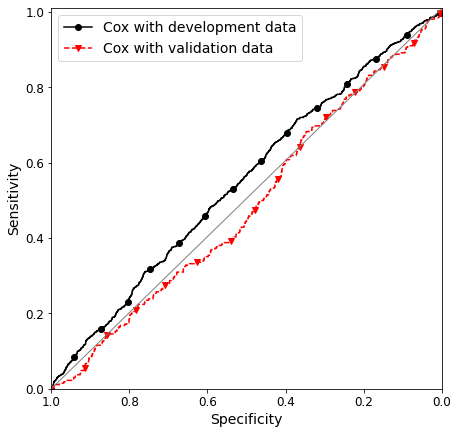

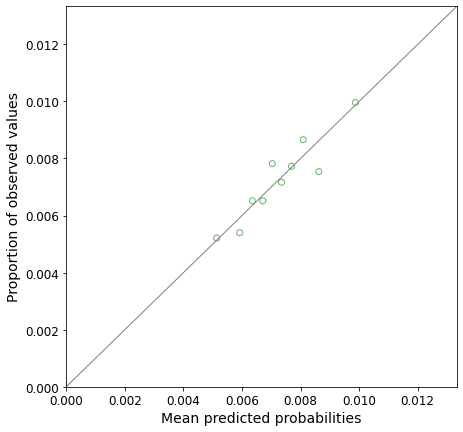

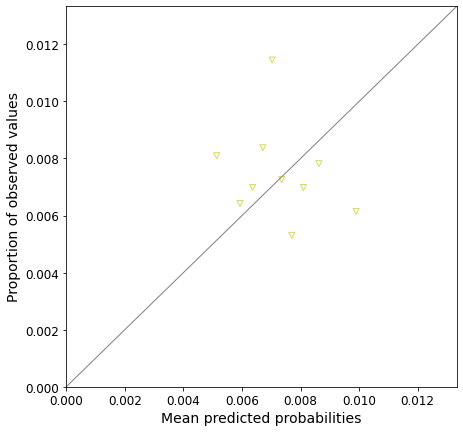

In [171]:
#data prep
data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

try:
    #build cox model 
    cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = cox_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_lrti_no_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_incdt.csv', data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt, 'sum_betas_cph_lrti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_lrti_no_abs_incdt, 'event_lrti_admitted', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, 'event_lrti_admitted', data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_incdt_train.jpg', 'calibration_cph_lrti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 12110 total observations, 12031 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12110
number of events observed = 79
   partial log-likelihood = -717.22
         time fit was run = 2022-11-22 12:41:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.65       1.91       0.43            -0.19             1.48                 0.83                 4.40
CCI_cat[T.medium]                0.75       2.12       0.45            -0.14             1.64                 0.87                 5.17
CCI_cat[T.high]                  1.44       4.24       0.45             0.55             2.34                 1.74                10.34
CCI_cat[T.very_high]             0.81       2.24       0.46            -0.10             1.71                 0.90                 5.55
age_cat[T.25_34]                 0.22       1.25       0.44            -0.64             1.09                 0.53                 2.98
age_cat[T.35_44]                -0.13       0.88       0.49            -1.08             0.82                 0.34                 2.28
age_cat[T.45_54]                 0.55       1.73       0.42            -0.27             1.37                 0.76                 3.92
age_cat[T.55_64]                 0.35       1.42       0.43            -0.49             1.19                 0.61                 3.29
age_cat[T.65_74]                 0.04       1.04       0.46            -0.86             0.94                 0.42                 2.57
age_cat[T.75_more]               0.11       1.11       0.46            -0.80             1.01                 0.45                 2.74
antibacterial_brit               0.08       1.09       0.08            -0.07             0.23                 0.93                 1.26
bmi_cat[T.obese]                -0.18       0.83       0.42            -1.00             0.63                 0.37                 1.88
bmi_cat[T.overweight]            0.10       1.10       0.49            -0.87             1.07                 0.42                 2.90
bmi_cat[T.underweight]          -0.20       0.82       0.80            -1.78             1.37                 0.17                 3.95
bmi_cat[T.unknown]               0.23       1.25       0.43            -0.61             1.07                 0.54                 2.91
ethnicity[T.unknown]             0.37       1.44       0.40            -0.42             1.15                 0.66                 3.16
ethnicity[T.white]               0.35       1.42       0.36            -0.36             1.06                 0.69                 2.89
flu_vaccine[T.yes]              -0.24       0.78       0.40            -1.02             0.53                 0.36                 1.71
imd[T.medium]                   -0.25       0.78       0.36            -0.95             0.45                 0.39                 1.57
imd[T.unaffluent]                0.03       1.03       0.33            -0.62             0.69                 0.54                 1.99
imd[T.unknown]                  -1.55       0.21       1.03            -3.57             0.46                 0.03                 1.59
imd[T.very_affluent]            -0.37       0.69       0.37            -1.11             0.36                 0.33                 1.43
imd[T.very_unaffluent]          -0.05       0.95       0.34            -0.72             0.63                 0.48                 1.87
region[T.east_midlands]         -0.10       0.90       0.52            -1.12             0.91                 0.33                 2.49
region[T.london]                 0.26       1.29       0.42           

12773


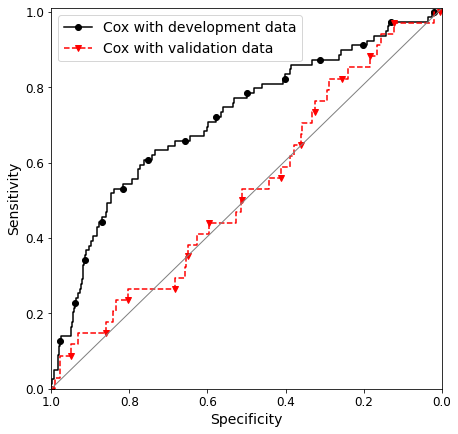

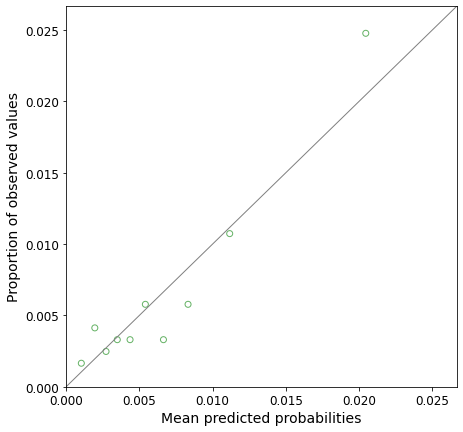

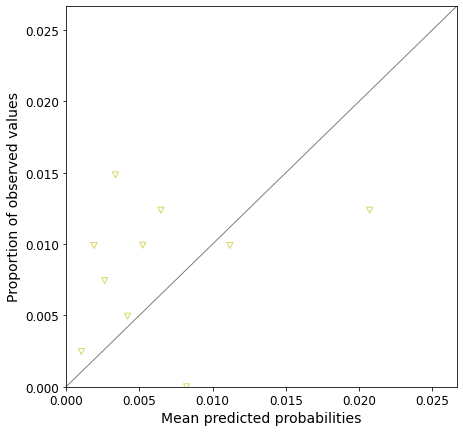

In [172]:
#data prep
data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_incdt', data_lrti_abs_incdt)

try:
    #build cox model 
    cph_lrti_abs_incdt, data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = cox_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_lrti_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_incdt.csv', data_lrti_abs_incdt_enc, data_lrti_abs_incdt, 'sum_betas_cph_lrti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_lrti_abs_incdt, 'event_lrti_admitted', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_lrti_abs_incdt, data_lrti_abs_incdt_train, 'event_lrti_admitted', data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_incdt_train.jpg', 'calibration_cph_lrti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_abs_incdt, 'lrti', 'abs_incdt', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 12028 total observations, 11955 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12028
number of events observed = 73
   partial log-likelihood = -670.22
         time fit was run = 2022-11-22 12:41:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.24       1.28       0.32            -0.38             0.86                 0.69                 2.37
CCI_cat[T.medium]               -0.27       0.76       0.39            -1.04             0.50                 0.35                 1.65
CCI_cat[T.high]                 -0.64       0.53       0.57            -1.75             0.47                 0.17                 1.60
CCI_cat[T.very_high]            -0.44       0.64       0.44            -1.31             0.43                 0.27                 1.53
age_cat[T.25_34]                 0.14       1.15       0.41            -0.66             0.95                 0.52                 2.58
age_cat[T.35_44]                -0.34       0.71       0.45            -1.23             0.54                 0.29                 1.71
age_cat[T.45_54]                -0.03       0.97       0.42            -0.85             0.79                 0.43                 2.21
age_cat[T.55_64]                -0.07       0.94       0.43            -0.90             0.77                 0.41                 2.16
age_cat[T.65_74]                -0.65       0.52       0.51            -1.64             0.35                 0.19                 1.42
age_cat[T.75_more]              -0.05       0.95       0.43            -0.89             0.79                 0.41                 2.20
antibacterial_brit               0.08       1.08       0.08            -0.08             0.23                 0.92                 1.26
bmi_cat[T.obese]                -0.25       0.78       0.42            -1.07             0.57                 0.34                 1.76
bmi_cat[T.overweight]           -0.28       0.75       0.54            -1.33             0.77                 0.26                 2.15
bmi_cat[T.underweight]           0.46       1.58       0.63            -0.77             1.69                 0.46                 5.41
bmi_cat[T.unknown]               0.03       1.03       0.43            -0.83             0.88                 0.44                 2.41
ethnicity[T.unknown]            -0.10       0.91       0.36            -0.80             0.60                 0.45                 1.83
ethnicity[T.white]              -0.29       0.75       0.32            -0.92             0.34                 0.40                 1.40
flu_vaccine[T.yes]               0.13       1.14       0.38            -0.61             0.87                 0.54                 2.38
imd[T.medium]                   -0.53       0.59       0.38            -1.28             0.22                 0.28                 1.25
imd[T.unaffluent]               -0.27       0.76       0.36            -0.97             0.43                 0.38                 1.54
imd[T.unknown]                  -0.96       0.38       0.75            -2.42             0.50                 0.09                 1.65
imd[T.very_affluent]            -0.50       0.61       0.38            -1.25             0.25                 0.29                 1.29
imd[T.very_unaffluent]          -0.04       0.96       0.34            -0.71             0.62                 0.49                 1.86
region[T.east_midlands]          0.07       1.07       0.58            -1.06             1.21                 0.35                 3.34
region[T.london]                 0.10       1.11       0.49           

12780


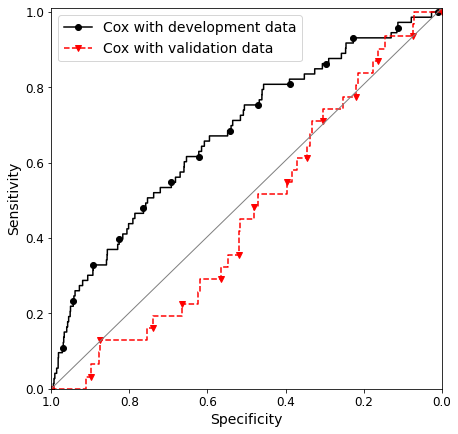

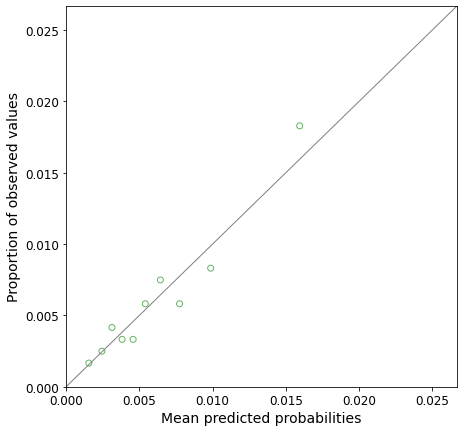

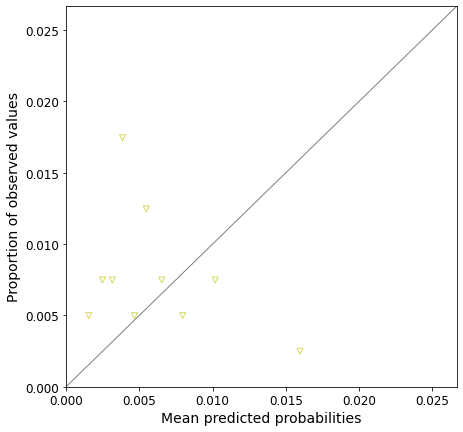

In [173]:
#data prep
data, data_lrti_no_abs_prevl_enc = cox_data_prep(data_lrti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)

try:
    #build cox model 
    cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test = cox_model_build('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_lrti_no_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_prevl.csv', data_lrti_no_abs_prevl_enc, data_lrti_no_abs_prevl, 'sum_betas_cph_lrti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_lrti_no_abs_prevl, 'event_lrti_admitted', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, 'event_lrti_admitted', data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_prevl_train.jpg', 'calibration_cph_lrti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_no_abs_prevl, 'lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent lrti with antibiotics

In [174]:
#data prep
data, data_lrti_abs_prevl_enc = cox_data_prep(data_lrti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_prevl', data_lrti_abs_prevl)

try:
    #build cox model 
    cph_lrti_abs_prevl, data_lrti_abs_prevl_train, data_lrti_abs_prevl_test = cox_model_build('lrti', 'abs_prevl', data_lrti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_lrti_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_prevl.csv', data_lrti_abs_prevl_enc, data_lrti_abs_prevl, 'sum_betas_cph_lrti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_lrti_abs_prevl, 'event_lrti_admitted', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_lrti_abs_prevl, data_lrti_abs_prevl_train, 'event_lrti_admitted', data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_prevl_train.jpg', 'calibration_cph_lrti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_abs_prevl, 'lrti', 'abs_prevl', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1293 total observations, 1283 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1293
number of events observed = 10
   partial log-likelihood = -49.41
         time fit was run = 2022-11-22 12:42:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.42       0.24       0.99            -3.37             0.53                 0.03                 1.70
CCI_cat[T.medium]               -0.90       0.41       1.02            -2.89             1.09                 0.06                 2.98
CCI_cat[T.high]                  1.07       2.91       0.95            -0.79             2.93                 0.45                18.80
CCI_cat[T.very_high]           -19.17       0.00    6844.23        -13433.61         13395.27                 0.00                  inf
age_cat[T.25_34]                 0.59       1.80       1.11            -1.58             2.76                 0.21                15.83
age_cat[T.35_44]                -0.99       0.37       1.37            -3.67             1.68                 0.03                 5.38
age_cat[T.45_54]                -0.57       0.56       1.22            -2.95             1.81                 0.05                 6.12
age_cat[T.55_64]                -1.05       0.35       1.33            -3.66             1.57                 0.03                 4.78
age_cat[T.65_74]                -1.07       0.34       1.39            -3.81             1.66                 0.02                 5.25
age_cat[T.75_more]              -0.91       0.40       1.39            -3.63             1.81                 0.03                 6.09
antibacterial_brit               0.18       1.20       0.27            -0.34             0.70                 0.71                 2.01
bmi_cat[T.obese]                19.10   1.98e+08    8427.58        -16498.65         16536.86                 0.00                  inf
bmi_cat[T.overweight]           18.79   1.45e+08    8427.58        -16498.97         16536.55                 0.00                  inf
bmi_cat[T.underweight]          -0.23       0.79   16985.94        -33292.06         33291.60                 0.00                  inf
bmi_cat[T.unknown]              18.01   6.65e+07    8427.58        -16499.74         16535.77                 0.00                  inf
ethnicity[T.unknown]             0.80       2.23       1.27            -1.69             3.30                 0.18                27.06
ethnicity[T.white]               0.42       1.53       1.21            -1.94             2.79                 0.14                16.26
flu_vaccine[T.yes]               0.09       1.09       1.21            -2.28             2.45                 0.10                11.61
imd[T.medium]                    1.42       4.14       0.99            -0.53             3.37                 0.59                29.01
imd[T.unaffluent]                0.07       1.07       1.33            -2.54             2.68                 0.08                14.62
imd[T.unknown]                 -18.87       0.00   10269.66        -20147.03         20109.30                 0.00                  inf
imd[T.very_affluent]            -0.12       0.89       1.38            -2.82             2.59                 0.06                13.32
imd[T.very_unaffluent]           0.62       1.86       1.14            -1.61             2.85                 0.20                17.29
region[T.east_midlands]         -0.87       0.42       1.31            -3.45             1.70                 0.03                 5.49
region[T.london]                -1.41       0.25       1.32            -3.

12921

error_3: roc curves or calibration curves failed.

error_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


ValueError: arange: cannot compute length

<Figure size 504x504 with 1 Axes>

### 5-5- incident lrti

In [ ]:
#data prep
data, data_lrti_incdt_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'incdt', data_lrti_incdt_enc)
make_summary_table_hosped('lrti', 'incdt', data_lrti_incdt)

try:
    cph_lrti_incdt, data_lrti_incdt_train, data_lrti_incdt_test = cox_model_abs_build('lrti', 'incdt', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt, 'lrti', 'incdt', data_lrti_incdt_train, data_lrti_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71816 total observations, 71298 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 71816
number of events observed = 518
   partial log-likelihood = -5775.76
         time fit was run = 2022-11-17 10:26:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.25       0.13            -0.04             0.49                 0.96                 1.63
CCI_cat[T.medium]                0.18       1.20       0.15            -0.11             0.47                 0.90                 1.61
CCI_cat[T.high]                  0.33       1.40       0.17            -0.00             0.67                 1.00                 1.95
CCI_cat[T.very_high]             0.16       1.17       0.16            -0.15             0.47                 0.86                 1.60
age_cat[T.25_34]                -0.01       0.99       0.17            -0.34             0.32                 0.71                 1.38
age_cat[T.35_44]                 0.14       1.15       0.16            -0.18             0.45                 0.83                 1.57
age_cat[T.45_54]                -0.08       0.92       0.17            -0.42             0.25                 0.66                 1.29
age_cat[T.55_64]                 0.01       1.01       0.17            -0.32             0.33                 0.73                 1.39
age_cat[T.65_74]                 0.17       1.18       0.16            -0.14             0.48                 0.87                 1.62
age_cat[T.75_more]              -0.09       0.92       0.17            -0.42             0.25                 0.66                 1.28
antibacterial_brit               0.04       1.04       0.03            -0.02             0.10                 0.98                 1.11
bmi_cat[T.obese]                 0.00       1.00       0.17            -0.33             0.33                 0.72                 1.39
bmi_cat[T.overweight]            0.07       1.07       0.20            -0.33             0.46                 0.72                 1.59
bmi_cat[T.underweight]           0.36       1.44       0.26            -0.14             0.87                 0.87                 2.39
bmi_cat[T.unknown]               0.04       1.05       0.18            -0.30             0.39                 0.74                 1.48
ethnicity[T.unknown]             0.24       1.27       0.15            -0.05             0.53                 0.95                 1.70
ethnicity[T.white]               0.15       1.16       0.14            -0.11             0.42                 0.89                 1.52
flu_vaccine[T.yes]              -0.04       0.96       0.15            -0.33             0.25                 0.72                 1.28
imd[T.medium]                    0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
imd[T.unaffluent]                0.01       1.01       0.14            -0.27             0.28                 0.77                 1.32
imd[T.unknown]                  -0.33       0.72       0.24            -0.81             0.15                 0.45                 1.16
imd[T.very_affluent]            -0.07       0.93       0.14            -0.35             0.20                 0.70                 1.23
imd[T.very_unaffluent]          -0.08       0.93       0.14            -0.36             0.20                 0.70                 1.23
lrti_ab_date                    -0.04       0.96       0.15            -0.33             0.24                 0.72                 1.28
region[T.east_midlands]         -0.07       0.93       0.20         

13037


### 5-6- hospital admission related to prevalent lrti

In [ ]:
#data prep
data, data_lrti_prevl_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'prevl', data_lrti_prevl_enc)
make_summary_table_hosped('lrti', 'prevl', data_lrti_prevl)

try:
    cph_lrti_prevl, data_lrti_prevl_train, data_lrti_prevl_test = cox_model_abs_build('lrti', 'prevl', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl, 'lrti', 'prevl', data_lrti_prevl_train, data_lrti_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8011 total observations, 7960 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8011
number of events observed = 51
   partial log-likelihood = -443.59
         time fit was run = 2022-11-17 10:26:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.38            -0.66             0.84                 0.52                 2.32
CCI_cat[T.medium]               -0.23       0.79       0.46            -1.14             0.67                 0.32                 1.95
CCI_cat[T.high]                 -0.38       0.68       0.59            -1.55             0.78                 0.21                 2.18
CCI_cat[T.very_high]            -0.40       0.67       0.52            -1.42             0.61                 0.24                 1.84
age_cat[T.25_34]                 0.00       1.00       0.46            -0.90             0.91                 0.41                 2.48
age_cat[T.35_44]                -0.54       0.58       0.53            -1.58             0.50                 0.21                 1.64
age_cat[T.45_54]                -0.47       0.62       0.53            -1.51             0.56                 0.22                 1.76
age_cat[T.55_64]                -0.07       0.94       0.47            -0.99             0.86                 0.37                 2.37
age_cat[T.65_74]                -0.88       0.42       0.60            -2.06             0.30                 0.13                 1.35
age_cat[T.75_more]              -0.33       0.72       0.51            -1.32             0.66                 0.27                 1.93
antibacterial_brit               0.09       1.09       0.10            -0.10             0.28                 0.90                 1.32
bmi_cat[T.obese]                 0.31       1.36       0.61            -0.89             1.51                 0.41                 4.53
bmi_cat[T.overweight]            0.44       1.56       0.71            -0.95             1.83                 0.39                 6.24
bmi_cat[T.underweight]           1.32       3.73       0.77            -0.19             2.82                 0.83                16.76
bmi_cat[T.unknown]               0.47       1.59       0.64            -0.78             1.72                 0.46                 5.56
ethnicity[T.unknown]            -0.06       0.95       0.45            -0.94             0.83                 0.39                 2.29
ethnicity[T.white]              -0.10       0.90       0.40            -0.89             0.68                 0.41                 1.97
flu_vaccine[T.yes]               0.26       1.29       0.44            -0.60             1.11                 0.55                 3.04
imd[T.medium]                    0.09       1.09       0.44            -0.77             0.95                 0.46                 2.58
imd[T.unaffluent]               -0.04       0.96       0.45            -0.92             0.84                 0.40                 2.32
imd[T.unknown]                 -16.90       0.00    2737.55         -5382.40          5348.60                 0.00                  inf
imd[T.very_affluent]            -0.22       0.80       0.48            -1.16             0.71                 0.31                 2.03
imd[T.very_unaffluent]           0.18       1.20       0.43            -0.66             1.02                 0.52                 2.78
lrti_ab_date                    -0.21       0.81       0.52            -1.23             0.81                 0.29                 2.26
region[T.east_midlands]         -0.07       0.93       0.61            -1

13052


### 5-7- hospital admission related to incident lrti with prescribed antibiotics categories

In [ ]:
#data prep
data, data_lrti_incdt_abs_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_abs, data_lrti_incdt_abs_train, data_lrti_incdt_abs_test = cox_model_ab_type_build('lrti', 'incdt_ab_type', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_abs, 'lrti', 'incdt_abs', data_lrti_incdt_abs_train, data_lrti_incdt_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71816 total observations, 71298 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 71816
number of events observed = 518
   partial log-likelihood = -5771.83
         time fit was run = 2022-11-17 10:26:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.25       0.13            -0.04             0.49                 0.97                 1.63
CCI_cat[T.medium]                0.18       1.20       0.15            -0.11             0.47                 0.90                 1.61
CCI_cat[T.high]                  0.33       1.40       0.17             0.00             0.67                 1.00                 1.95
CCI_cat[T.very_high]             0.16       1.17       0.16            -0.15             0.47                 0.86                 1.60
ab_type_cat[T.Doxycycline]       0.03       1.03    1820.50         -3568.09          3568.14                 0.00                  inf
ab_type_cat[T.no]               14.81   2.71e+06     977.25         -1900.56          1930.19                 0.00                  inf
ab_type_cat[T.other]            14.84   2.80e+06     977.25         -1900.53          1930.22                 0.00                  inf
age_cat[T.25_34]                -0.01       0.99       0.17            -0.34             0.32                 0.71                 1.38
age_cat[T.35_44]                 0.14       1.15       0.16            -0.18             0.45                 0.84                 1.57
age_cat[T.45_54]                -0.08       0.92       0.17            -0.42             0.25                 0.66                 1.29
age_cat[T.55_64]                 0.01       1.01       0.17            -0.32             0.33                 0.73                 1.40
age_cat[T.65_74]                 0.17       1.19       0.16            -0.14             0.48                 0.87                 1.62
age_cat[T.75_more]              -0.08       0.92       0.17            -0.42             0.25                 0.66                 1.28
antibacterial_brit               0.04       1.04       0.03            -0.02             0.10                 0.98                 1.11
bmi_cat[T.obese]                -0.00       1.00       0.17            -0.33             0.33                 0.72                 1.39
bmi_cat[T.overweight]            0.06       1.07       0.20            -0.33             0.46                 0.72                 1.58
bmi_cat[T.underweight]           0.36       1.44       0.26            -0.15             0.87                 0.86                 2.39
bmi_cat[T.unknown]               0.04       1.04       0.18            -0.30             0.39                 0.74                 1.48
ethnicity[T.unknown]             0.24       1.27       0.15            -0.05             0.53                 0.95                 1.70
ethnicity[T.white]               0.15       1.16       0.14            -0.11             0.42                 0.89                 1.52
flu_vaccine[T.yes]              -0.04       0.96       0.15            -0.34             0.25                 0.71                 1.28
imd[T.medium]                    0.02       1.02       0.14            -0.26             0.29                 0.77                 1.34
imd[T.unaffluent]                0.01       1.01       0.14            -0.27             0.28                 0.77                 1.32
imd[T.unknown]                  -0.33       0.72       0.24            -0.81             0.15                 0.45                 1.16
imd[T.very_affluent]            -0.07       0.93       0.14         

13631


### 5-8- hospital admission related to prevalent lrti with prescribed antibiotics categories

In [ ]:
#data prep
data, data_lrti_prevl_abs_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_abs, data_lrti_prevl_abs_train, data_lrti_prevl_abs_test = cox_model_ab_type_build('lrti', 'prevl_ab_type', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_abs, 'lrti', 'prevl_abs', data_lrti_prevl_abs_train, data_lrti_prevl_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8011 total observations, 7960 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8011
number of events observed = 51
   partial log-likelihood = -443.24
         time fit was run = 2022-11-17 10:26:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.38            -0.66             0.84                 0.52                 2.33
CCI_cat[T.medium]               -0.23       0.79       0.46            -1.14             0.67                 0.32                 1.95
CCI_cat[T.high]                 -0.39       0.68       0.59            -1.55             0.78                 0.21                 2.18
CCI_cat[T.very_high]            -0.41       0.67       0.52            -1.42             0.61                 0.24                 1.84
ab_type_cat[T.Doxycycline]       0.16       1.18   19887.36        -38978.34         38978.67                 0.00                  inf
ab_type_cat[T.no]               16.78   1.93e+07    7207.24        -14109.15         14142.71                 0.00                  inf
ab_type_cat[T.other]            16.66   1.71e+07    7207.24        -14109.28         14142.59                 0.00                  inf
age_cat[T.25_34]                 0.01       1.01       0.46            -0.90             0.91                 0.41                 2.48
age_cat[T.35_44]                -0.54       0.58       0.53            -1.57             0.50                 0.21                 1.65
age_cat[T.45_54]                -0.47       0.62       0.53            -1.51             0.56                 0.22                 1.76
age_cat[T.55_64]                -0.06       0.94       0.47            -0.99             0.87                 0.37                 2.38
age_cat[T.65_74]                -0.88       0.41       0.60            -2.06             0.30                 0.13                 1.35
age_cat[T.75_more]              -0.33       0.72       0.51            -1.32             0.66                 0.27                 1.93
antibacterial_brit               0.09       1.09       0.10            -0.10             0.28                 0.90                 1.32
bmi_cat[T.obese]                 0.31       1.37       0.61            -0.89             1.52                 0.41                 4.55
bmi_cat[T.overweight]            0.45       1.56       0.71            -0.94             1.83                 0.39                 6.26
bmi_cat[T.underweight]           1.33       3.79       0.77            -0.17             2.84                 0.84                17.05
bmi_cat[T.unknown]               0.47       1.60       0.64            -0.78             1.72                 0.46                 5.58
ethnicity[T.unknown]            -0.07       0.94       0.45            -0.95             0.82                 0.39                 2.27
ethnicity[T.white]              -0.12       0.89       0.40            -0.90             0.67                 0.41                 1.95
flu_vaccine[T.yes]               0.26       1.30       0.44            -0.60             1.11                 0.55                 3.05
imd[T.medium]                    0.09       1.09       0.44            -0.77             0.95                 0.46                 2.58
imd[T.unaffluent]               -0.04       0.96       0.45            -0.92             0.84                 0.40                 2.31
imd[T.unknown]                 -16.85       0.00    2658.25         -5226.92          5193.23                 0.00                  inf
imd[T.very_affluent]            -0.23       0.80       0.48            -1

13654


### 5-9- stratified by sex
#### 5-9-1- incident males

In [ ]:
#data prep
data, data_lrti_incdt_males_enc = cox_data_prep(data_lrti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_males, data_lrti_incdt_males_train, data_lrti_incdt_males_test = cox_model_strat_sex_build('lrti', 'incdt_males', data_lrti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_males, 'lrti', 'incdt_males', data_lrti_incdt_males_train, data_lrti_incdt_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35019 total observations, 34801 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 35019
number of events observed = 218
   partial log-likelihood = -2265.19
         time fit was run = 2022-11-17 10:26:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.20            -0.39             0.38                 0.68                 1.46
CCI_cat[T.medium]                0.02       1.02       0.22            -0.41             0.44                 0.66                 1.56
CCI_cat[T.high]                  0.13       1.14       0.26            -0.37             0.63                 0.69                 1.89
CCI_cat[T.very_high]             0.05       1.05       0.23            -0.41             0.50                 0.67                 1.65
age_cat[T.25_34]                -0.13       0.88       0.27            -0.66             0.40                 0.52                 1.49
age_cat[T.35_44]                 0.18       1.19       0.25            -0.32             0.67                 0.73                 1.95
age_cat[T.45_54]                -0.03       0.97       0.27            -0.55             0.49                 0.58                 1.63
age_cat[T.55_64]                 0.09       1.09       0.26            -0.41             0.59                 0.66                 1.81
age_cat[T.65_74]                 0.16       1.18       0.25            -0.33             0.66                 0.72                 1.93
age_cat[T.75_more]               0.16       1.17       0.25            -0.34             0.65                 0.71                 1.92
antibacterial_brit              -0.00       1.00       0.05            -0.10             0.09                 0.91                 1.10
bmi_cat[T.obese]                 0.12       1.13       0.26            -0.39             0.63                 0.68                 1.88
bmi_cat[T.overweight]            0.20       1.22       0.31            -0.41             0.81                 0.66                 2.25
bmi_cat[T.underweight]           0.41       1.51       0.40            -0.37             1.19                 0.69                 3.30
bmi_cat[T.unknown]              -0.04       0.96       0.28            -0.59             0.51                 0.55                 1.67
ethnicity[T.unknown]             0.47       1.60       0.23             0.03             0.91                 1.03                 2.49
ethnicity[T.white]               0.12       1.13       0.21            -0.30             0.54                 0.74                 1.71
flu_vaccine[T.yes]               0.05       1.05       0.23            -0.40             0.49                 0.67                 1.63
imd[T.medium]                    0.12       1.13       0.22            -0.31             0.55                 0.73                 1.74
imd[T.unaffluent]                0.07       1.07       0.22            -0.37             0.51                 0.69                 1.66
imd[T.unknown]                  -0.07       0.93       0.35            -0.77             0.62                 0.46                 1.87
imd[T.very_affluent]             0.05       1.05       0.22            -0.39             0.48                 0.68                 1.62
imd[T.very_unaffluent]           0.06       1.06       0.22            -0.37             0.50                 0.69                 1.64
lrti_ab_date                    -0.68       0.51       0.30            -1.26            -0.10                 0.28                 0.91
region[T.east_midlands]         -0.04       0.96       0.31         

12759


#### 5-9-2- incident females

In [ ]:
#data prep
data, data_lrti_incdt_females_enc = cox_data_prep(data_lrti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_females, data_lrti_incdt_females_train, data_lrti_incdt_females_test = cox_model_strat_sex_build('lrti', 'incdt_females', data_lrti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_females, 'lrti', 'incdt_females', data_lrti_incdt_females_train, data_lrti_incdt_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36796 total observations, 36496 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 36796
number of events observed = 300
   partial log-likelihood = -3129.30
         time fit was run = 2022-11-17 10:26:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.29       0.18            -0.10             0.61                 0.90                 1.84
CCI_cat[T.medium]                0.39       1.48       0.20             0.00             0.78                 1.00                 2.17
CCI_cat[T.high]                  0.44       1.56       0.23            -0.00             0.89                 1.00                 2.43
CCI_cat[T.very_high]             0.27       1.32       0.21            -0.14             0.69                 0.87                 1.98
age_cat[T.25_34]                 0.25       1.29       0.22            -0.17             0.68                 0.84                 1.96
age_cat[T.35_44]                 0.32       1.37       0.21            -0.10             0.74                 0.90                 2.09
age_cat[T.45_54]                -0.11       0.89       0.24            -0.58             0.35                 0.56                 1.42
age_cat[T.55_64]                -0.15       0.86       0.24            -0.62             0.31                 0.54                 1.36
age_cat[T.65_74]                 0.26       1.30       0.22            -0.16             0.68                 0.85                 1.98
age_cat[T.75_more]               0.04       1.04       0.23            -0.41             0.49                 0.67                 1.63
antibacterial_brit               0.01       1.01       0.04            -0.07             0.09                 0.93                 1.09
bmi_cat[T.obese]                 0.34       1.40       0.26            -0.16             0.84                 0.85                 2.32
bmi_cat[T.overweight]            0.38       1.47       0.30            -0.20             0.97                 0.82                 2.63
bmi_cat[T.underweight]           0.90       2.47       0.35             0.22             1.59                 1.25                 4.89
bmi_cat[T.unknown]               0.42       1.53       0.27            -0.10             0.95                 0.91                 2.58
ethnicity[T.unknown]            -0.15       0.86       0.19            -0.52             0.22                 0.60                 1.25
ethnicity[T.white]              -0.07       0.93       0.16            -0.39             0.25                 0.68                 1.28
flu_vaccine[T.yes]              -0.06       0.94       0.20            -0.44             0.33                 0.64                 1.39
imd[T.medium]                   -0.14       0.87       0.18            -0.50             0.22                 0.61                 1.25
imd[T.unaffluent]                0.04       1.04       0.18            -0.31             0.39                 0.74                 1.47
imd[T.unknown]                  -0.62       0.54       0.36            -1.32             0.08                 0.27                 1.08
imd[T.very_affluent]            -0.20       0.82       0.19            -0.56             0.17                 0.57                 1.18
imd[T.very_unaffluent]          -0.12       0.89       0.18            -0.48             0.24                 0.62                 1.27
lrti_ab_date                     0.28       1.33       0.17            -0.06             0.63                 0.95                 1.87
region[T.east_midlands]         -0.30       0.74       0.28         

12764


#### 5-9-3- prevalent males

In [ ]:
#data prep
data, data_lrti_prevl_males_enc = cox_data_prep(data_lrti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_males, data_lrti_prevl_males_train, data_lrti_prevl_males_test = cox_model_strat_sex_build('lrti', 'prevl_males', data_lrti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_lrti_prevl_males, 'lrti', 'prevl_males', data_lrti_prevl_males_train, data_lrti_prevl_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3883 total observations, 3859 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3883
number of events observed = 24
   partial log-likelihood = -173.77
         time fit was run = 2022-11-17 10:27:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.57            -1.21             1.03                 0.30                 2.80
CCI_cat[T.medium]               -0.57       0.56       0.74            -2.02             0.87                 0.13                 2.40
CCI_cat[T.high]                 -0.33       0.72       0.85            -1.99             1.33                 0.14                 3.79
CCI_cat[T.very_high]             0.03       1.03       0.65            -1.24             1.30                 0.29                 3.66
age_cat[T.25_34]                -1.19       0.30       0.83            -2.81             0.43                 0.06                 1.54
age_cat[T.35_44]                -0.87       0.42       0.72            -2.29             0.54                 0.10                 1.72
age_cat[T.45_54]                -1.20       0.30       0.83            -2.83             0.43                 0.06                 1.53
age_cat[T.55_64]                -0.02       0.98       0.59            -1.18             1.15                 0.31                 3.15
age_cat[T.65_74]                -0.79       0.45       0.72            -2.21             0.63                 0.11                 1.87
age_cat[T.75_more]              -1.32       0.27       0.83            -2.95             0.31                 0.05                 1.36
antibacterial_brit               0.15       1.16       0.14            -0.13             0.42                 0.88                 1.52
bmi_cat[T.obese]                17.83   5.55e+07    5234.25        -10241.10         10276.77                 0.00                  inf
bmi_cat[T.overweight]           17.64   4.60e+07    5234.25        -10241.29         10276.58                 0.00                  inf
bmi_cat[T.underweight]          18.97   1.73e+08    5234.25        -10239.96         10277.90                 0.00                  inf
bmi_cat[T.unknown]              18.20   8.00e+07    5234.25        -10240.74         10277.13                 0.00                  inf
ethnicity[T.unknown]             0.08       1.08       0.56            -1.03             1.18                 0.36                 3.27
ethnicity[T.white]              -0.85       0.43       0.57            -1.96             0.27                 0.14                 1.31
flu_vaccine[T.yes]               0.85       2.33       0.52            -0.17             1.86                 0.85                 6.42
imd[T.medium]                    0.69       2.00       0.62            -0.53             1.92                 0.59                 6.80
imd[T.unaffluent]               -0.29       0.75       0.77            -1.81             1.23                 0.16                 3.41
imd[T.unknown]                 -17.69       0.00    5964.89        -11708.65         11673.28                 0.00                  inf
imd[T.very_affluent]             0.25       1.28       0.69            -1.10             1.59                 0.33                 4.91
imd[T.very_unaffluent]           0.12       1.13       0.72            -1.29             1.53                 0.28                 4.63
lrti_ab_date                   -17.86       0.00    5251.95        -10311.49         10275.76                 0.00                  inf
region[T.east_midlands]          0.29       1.34       0.72            -1

12868


#### 5-9-4- prevalent females

In [ ]:
try:
    #data prep
    data, data_lrti_prevl_females_enc = cox_data_prep(data_lrti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

    #cox model
    cph_lrti_prevl_females, data_lrti_prevl_females_train, data_lrti_prevl_females_test = cox_model_strat_sex_build('lrti', 'prevl_females', data_lrti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_females, 'lrti', 'prevl_females', data_lrti_prevl_females_train, data_lrti_prevl_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4128 total observations, 4101 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 4128
number of events observed = 27
   partial log-likelihood = -210.48
         time fit was run = 2022-11-17 10:27:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.38       0.68       0.50            -1.36             0.60                 0.26                 1.82
CCI_cat[T.medium]               -0.79       0.46       0.63            -2.03             0.45                 0.13                 1.58
CCI_cat[T.high]                 -0.22       0.80       0.70            -1.59             1.15                 0.20                 3.16
CCI_cat[T.very_high]            -0.82       0.44       0.70            -2.19             0.54                 0.11                 1.72
age_cat[T.25_34]                 0.32       1.38       0.65            -0.96             1.60                 0.38                 4.95
age_cat[T.35_44]                -0.76       0.47       0.87            -2.47             0.94                 0.08                 2.56
age_cat[T.45_54]                -0.12       0.89       0.71            -1.51             1.28                 0.22                 3.59
age_cat[T.55_64]                -0.36       0.70       0.77            -1.87             1.15                 0.15                 3.15
age_cat[T.65_74]                 0.22       1.24       0.65            -1.06             1.50                 0.35                 4.48
age_cat[T.75_more]              -0.73       0.48       0.87            -2.43             0.98                 0.09                 2.67
antibacterial_brit              -0.08       0.92       0.14            -0.36             0.20                 0.70                 1.23
bmi_cat[T.obese]                -0.88       0.42       0.60            -2.05             0.30                 0.13                 1.35
bmi_cat[T.overweight]           -0.96       0.38       0.87            -2.67             0.75                 0.07                 2.12
bmi_cat[T.underweight]           0.30       1.35       0.88            -1.42             2.02                 0.24                 7.57
bmi_cat[T.unknown]              -0.23       0.79       0.61            -1.43             0.97                 0.24                 2.63
ethnicity[T.unknown]            -0.64       0.52       0.64            -1.90             0.61                 0.15                 1.83
ethnicity[T.white]              -0.21       0.81       0.51            -1.22             0.79                 0.29                 2.21
flu_vaccine[T.yes]              -0.27       0.76       0.75            -1.73             1.19                 0.18                 3.28
imd[T.medium]                   -1.19       0.30       0.67            -2.51             0.13                 0.08                 1.14
imd[T.unaffluent]               -0.65       0.52       0.56            -1.76             0.45                 0.17                 1.57
imd[T.unknown]                 -16.56       0.00    2578.86         -5071.04          5037.92                 0.00                  inf
imd[T.very_affluent]            -0.36       0.70       0.53            -1.41             0.69                 0.24                 1.99
imd[T.very_unaffluent]          -0.73       0.48       0.61            -1.92             0.47                 0.15                 1.60
lrti_ab_date                     0.88       2.42       0.47            -0.04             1.80                 0.96                 6.07
region[T.east_midlands]          0.69       1.99       0.87            -1

12793


### 5-10- stratified by age category
#### 5-10-1- incident

In [ ]:
#data prep
data, data_lrti_incdt_15_24_enc = cox_data_prep(data_lrti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_15_24, data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test = cox_model_strat_age_build('lrti', 'incdt_15_24', data_lrti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_15_24, 'lrti', 'incdt_15_24', data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10051 total observations, 9981 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10051
number of events observed = 70
   partial log-likelihood = -623.43
         time fit was run = 2022-11-17 10:27:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.80       2.23       0.39             0.03             1.57                 1.03                 4.83
CCI_cat[T.medium]                0.40       1.50       0.44            -0.47             1.28                 0.63                 3.58
CCI_cat[T.high]                  0.56       1.75       0.50            -0.42             1.54                 0.66                 4.68
CCI_cat[T.very_high]            -0.41       0.66       0.57            -1.53             0.71                 0.22                 2.04
antibacterial_brit               0.02       1.02       0.08            -0.15             0.18                 0.86                 1.20
bmi_cat[T.obese]                -0.07       0.94       0.44            -0.94             0.80                 0.39                 2.24
bmi_cat[T.overweight]           -0.24       0.79       0.58            -1.37             0.89                 0.25                 2.44
bmi_cat[T.underweight]          -0.77       0.46       1.08            -2.89             1.35                 0.06                 3.84
bmi_cat[T.unknown]               0.28       1.32       0.46            -0.62             1.17                 0.54                 3.23
ethnicity[T.unknown]             0.02       1.02       0.38            -0.73             0.77                 0.48                 2.16
ethnicity[T.white]              -0.02       0.98       0.34            -0.69             0.65                 0.50                 1.91
flu_vaccine[T.yes]               0.27       1.31       0.36            -0.43             0.97                 0.65                 2.65
imd[T.medium]                   -0.29       0.75       0.44            -1.15             0.58                 0.32                 1.79
imd[T.unaffluent]               -0.23       0.80       0.43            -1.07             0.61                 0.34                 1.85
imd[T.unknown]                   0.30       1.35       0.58            -0.83             1.43                 0.43                 4.20
imd[T.very_affluent]             0.24       1.28       0.39            -0.52             1.00                 0.60                 2.73
imd[T.very_unaffluent]           0.56       1.74       0.37            -0.16             1.27                 0.85                 3.58
lrti_ab_date                    -1.35       0.26       0.72            -2.75             0.06                 0.06                 1.06
region[T.east_midlands]         -0.40       0.67       0.57            -1.52             0.72                 0.22                 2.06
region[T.london]                -0.61       0.54       0.49            -1.57             0.34                 0.21                 1.41
region[T.north_east]             0.42       1.52       0.46            -0.47             1.32                 0.62                 3.73
region[T.north_west]             0.14       1.15       0.48            -0.80             1.07                 0.45                 2.91
region[T.south_east]             0.17       1.19       0.48            -0.76             1.10                 0.47                 3.01
region[T.south_west]            -0.69       0.50       0.61            -1.89             0.51                 0.15                 1.66
region[T.west_midlands]         -0.46       0.63       0.57            

11397


In [ ]:
#data prep
data, data_lrti_incdt_25_34_enc = cox_data_prep(data_lrti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_25_34, data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test = cox_model_strat_age_build('lrti', 'incdt_25_34', data_lrti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_25_34, 'lrti', 'incdt_25_34', data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10324 total observations, 10252 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10324
number of events observed = 72
   partial log-likelihood = -645.72
         time fit was run = 2022-11-17 10:27:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.34            -0.87             0.47                 0.42                 1.60
CCI_cat[T.medium]               -0.22       0.80       0.39            -1.00             0.55                 0.37                 1.73
CCI_cat[T.high]                  0.05       1.05       0.44            -0.82             0.92                 0.44                 2.51
CCI_cat[T.very_high]             0.26       1.30       0.37            -0.46             0.98                 0.63                 2.67
antibacterial_brit               0.07       1.07       0.08            -0.09             0.23                 0.92                 1.26
bmi_cat[T.obese]                -0.06       0.95       0.44            -0.92             0.81                 0.40                 2.25
bmi_cat[T.overweight]            0.29       1.33       0.52            -0.73             1.30                 0.48                 3.67
bmi_cat[T.underweight]           0.28       1.33       0.71            -1.11             1.67                 0.33                 5.33
bmi_cat[T.unknown]              -0.04       0.96       0.47            -0.97             0.88                 0.38                 2.42
ethnicity[T.unknown]             0.44       1.56       0.39            -0.33             1.21                 0.72                 3.37
ethnicity[T.white]               0.05       1.05       0.37            -0.68             0.77                 0.51                 2.16
flu_vaccine[T.yes]              -0.01       0.99       0.40            -0.79             0.78                 0.45                 2.17
imd[T.medium]                    0.09       1.10       0.39            -0.68             0.86                 0.51                 2.37
imd[T.unaffluent]                0.58       1.79       0.35            -0.10             1.27                 0.90                 3.56
imd[T.unknown]                  -0.52       0.60       0.76            -2.01             0.97                 0.13                 2.64
imd[T.very_affluent]            -0.48       0.62       0.45            -1.36             0.40                 0.26                 1.50
imd[T.very_unaffluent]           0.10       1.10       0.39            -0.66             0.86                 0.52                 2.35
lrti_ab_date                     0.34       1.40       0.34            -0.33             1.01                 0.72                 2.73
region[T.east_midlands]         -0.71       0.49       0.54            -1.77             0.35                 0.17                 1.41
region[T.london]                -0.33       0.72       0.40            -1.10             0.45                 0.33                 1.58
region[T.north_east]            -0.21       0.81       0.47            -1.12             0.70                 0.33                 2.02
region[T.north_west]            -0.92       0.40       0.58            -2.07             0.22                 0.13                 1.25
region[T.south_east]            -0.03       0.97       0.44            -0.89             0.83                 0.41                 2.30
region[T.south_west]            -0.59       0.55       0.51            -1.59             0.41                 0.20                 1.50
region[T.west_midlands]         -0.20       0.82       0.47           

11404


In [ ]:
#data prep
data, data_lrti_incdt_35_44_enc = cox_data_prep(data_lrti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_35_44, data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test = cox_model_strat_age_build('lrti', 'incdt_35_44', data_lrti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_35_44, 'lrti', 'incdt_35_44', data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10317 total observations, 10232 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10317
number of events observed = 85
   partial log-likelihood = -763.78
         time fit was run = 2022-11-17 10:27:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.27       0.76       0.33            -0.91             0.37                 0.40                 1.44
CCI_cat[T.medium]                0.15       1.17       0.33            -0.50             0.81                 0.61                 2.24
CCI_cat[T.high]                 -0.16       0.85       0.45            -1.05             0.73                 0.35                 2.07
CCI_cat[T.very_high]             0.23       1.25       0.34            -0.45             0.90                 0.64                 2.46
antibacterial_brit               0.10       1.10       0.07            -0.04             0.24                 0.96                 1.28
bmi_cat[T.obese]                 0.18       1.19       0.44            -0.68             1.03                 0.51                 2.81
bmi_cat[T.overweight]            0.45       1.56       0.49            -0.52             1.42                 0.59                 4.12
bmi_cat[T.underweight]           0.24       1.27       0.71            -1.15             1.63                 0.32                 5.11
bmi_cat[T.unknown]               0.15       1.16       0.47            -0.76             1.07                 0.47                 2.91
ethnicity[T.unknown]             0.92       2.50       0.42             0.09             1.74                 1.10                 5.70
ethnicity[T.white]               0.46       1.58       0.41            -0.34             1.25                 0.71                 3.50
flu_vaccine[T.yes]               0.06       1.06       0.35            -0.64             0.76                 0.53                 2.13
imd[T.medium]                    0.27       1.30       0.39            -0.50             1.03                 0.61                 2.79
imd[T.unaffluent]                0.34       1.41       0.38            -0.41             1.09                 0.66                 2.98
imd[T.unknown]                   0.21       1.24       0.58            -0.92             1.35                 0.40                 3.85
imd[T.very_affluent]             0.46       1.58       0.37            -0.26             1.18                 0.77                 3.26
imd[T.very_unaffluent]           0.50       1.65       0.37            -0.23             1.23                 0.80                 3.41
lrti_ab_date                     0.30       1.35       0.32            -0.34             0.93                 0.71                 2.54
region[T.east_midlands]          0.72       2.05       0.55            -0.36             1.80                 0.70                 6.02
region[T.london]                 0.68       1.97       0.50            -0.30             1.66                 0.74                 5.26
region[T.north_east]            -0.56       0.57       0.73            -1.99             0.88                 0.14                 2.40
region[T.north_west]             0.85       2.34       0.53            -0.19             1.90                 0.82                 6.66
region[T.south_east]             1.13       3.10       0.52             0.11             2.15                 1.11                 8.62
region[T.south_west]            -0.04       0.96       0.63            -1.28             1.20                 0.28                 3.33
region[T.west_midlands]          0.63       1.89       0.56           

11374


In [ ]:
#data prep
data, data_lrti_incdt_45_54_enc = cox_data_prep(data_lrti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_45_54, data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test = cox_model_strat_age_build('lrti', 'incdt_45_54', data_lrti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_45_54, 'lrti', 'incdt_45_54', data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10110 total observations, 10042 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10110
number of events observed = 68
   partial log-likelihood = -607.33
         time fit was run = 2022-11-17 10:27:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.66       0.36            -1.11             0.29                 0.33                 1.33
CCI_cat[T.medium]               -0.51       0.60       0.43            -1.35             0.33                 0.26                 1.39
CCI_cat[T.high]                  0.79       2.21       0.36             0.08             1.50                 1.08                 4.50
CCI_cat[T.very_high]            -0.19       0.83       0.42            -1.00             0.63                 0.37                 1.87
antibacterial_brit              -0.05       0.95       0.09            -0.22             0.12                 0.80                 1.13
bmi_cat[T.obese]                 0.35       1.41       0.53            -0.69             1.38                 0.50                 3.99
bmi_cat[T.overweight]            0.17       1.19       0.63            -1.06             1.40                 0.35                 4.06
bmi_cat[T.underweight]           0.55       1.73       0.77            -0.95             2.05                 0.39                 7.77
bmi_cat[T.unknown]               0.56       1.74       0.55            -0.52             1.63                 0.59                 5.11
ethnicity[T.unknown]             0.18       1.20       0.40            -0.60             0.97                 0.55                 2.65
ethnicity[T.white]               0.04       1.04       0.37            -0.69             0.77                 0.50                 2.15
flu_vaccine[T.yes]              -0.93       0.39       0.59            -2.09             0.23                 0.12                 1.26
imd[T.medium]                   -0.75       0.47       0.39            -1.52             0.02                 0.22                 1.02
imd[T.unaffluent]               -0.56       0.57       0.37            -1.29             0.16                 0.28                 1.18
imd[T.unknown]                  -1.11       0.33       0.75            -2.57             0.35                 0.08                 1.42
imd[T.very_affluent]            -0.27       0.77       0.34            -0.93             0.40                 0.39                 1.49
imd[T.very_unaffluent]          -0.75       0.47       0.41            -1.55             0.04                 0.21                 1.04
lrti_ab_date                     0.45       1.57       0.34            -0.22             1.12                 0.80                 3.07
region[T.east_midlands]          0.89       2.44       0.60            -0.29             2.07                 0.75                 7.95
region[T.london]                 0.78       2.17       0.56            -0.32             1.87                 0.73                 6.52
region[T.north_east]             0.26       1.29       0.67            -1.06             1.57                 0.35                 4.82
region[T.north_west]             0.62       1.85       0.63            -0.61             1.85                 0.54                 6.34
region[T.south_east]             0.21       1.23       0.67            -1.11             1.53                 0.33                 4.60
region[T.south_west]             1.04       2.84       0.60            -0.14             2.22                 0.87                 9.23
region[T.west_midlands]          0.63       1.88       0.61           

11389


In [ ]:
#data prep
data, data_lrti_incdt_55_64_enc = cox_data_prep(data_lrti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_55_64, data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test = cox_model_strat_age_build('lrti', 'incdt_55_64', data_lrti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_55_64, 'lrti', 'incdt_55_64', data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10435 total observations, 10369 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10435
number of events observed = 66
   partial log-likelihood = -591.03
         time fit was run = 2022-11-17 10:27:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.22       1.24       0.38            -0.52             0.95                 0.60                 2.59
CCI_cat[T.medium]                0.55       1.74       0.39            -0.21             1.32                 0.81                 3.75
CCI_cat[T.high]                 -0.37       0.69       0.59            -1.54             0.79                 0.22                 2.20
CCI_cat[T.very_high]            -0.15       0.86       0.48            -1.08             0.78                 0.34                 2.19
antibacterial_brit               0.03       1.03       0.09            -0.14             0.20                 0.87                 1.22
bmi_cat[T.obese]                 0.78       2.18       0.73            -0.66             2.22                 0.52                 9.18
bmi_cat[T.overweight]            1.59       4.90       0.76             0.09             3.09                 1.09                21.95
bmi_cat[T.underweight]           1.63       5.11       0.87            -0.07             3.33                 0.93                28.02
bmi_cat[T.unknown]               1.16       3.18       0.74            -0.30             2.61                 0.74                13.64
ethnicity[T.unknown]            -0.47       0.62       0.40            -1.26             0.32                 0.28                 1.37
ethnicity[T.white]              -0.19       0.83       0.33            -0.83             0.46                 0.43                 1.58
flu_vaccine[T.yes]               0.32       1.38       0.36            -0.39             1.03                 0.68                 2.80
imd[T.medium]                   -0.16       0.85       0.37            -0.88             0.56                 0.41                 1.75
imd[T.unaffluent]               -0.39       0.68       0.39            -1.16             0.38                 0.31                 1.46
imd[T.unknown]                  -0.79       0.46       0.75            -2.26             0.69                 0.10                 1.99
imd[T.very_affluent]            -0.19       0.83       0.37            -0.91             0.53                 0.40                 1.70
imd[T.very_unaffluent]          -0.64       0.53       0.42            -1.46             0.18                 0.23                 1.19
lrti_ab_date                     0.03       1.03       0.40            -0.76             0.82                 0.47                 2.26
region[T.east_midlands]          0.39       1.48       0.57            -0.72             1.51                 0.48                 4.55
region[T.london]                -0.05       0.95       0.55            -1.12             1.03                 0.32                 2.79
region[T.north_east]            -0.26       0.77       0.67            -1.57             1.06                 0.21                 2.88
region[T.north_west]             0.15       1.16       0.61            -1.04             1.34                 0.35                 3.82
region[T.south_east]             0.39       1.48       0.59            -0.76             1.54                 0.47                 4.68
region[T.south_west]             0.69       1.98       0.55            -0.39             1.76                 0.68                 5.82
region[T.west_midlands]          0.56       1.75       0.56           

11398


In [ ]:
#data prep
data, data_lrti_incdt_65_74_enc = cox_data_prep(data_lrti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_65_74, data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test = cox_model_strat_age_build('lrti', 'incdt_65_74', data_lrti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_65_74, 'lrti', 'incdt_65_74', data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10326 total observations, 10248 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10326
number of events observed = 78
   partial log-likelihood = -705.43
         time fit was run = 2022-11-17 10:27:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.79       2.20       0.39             0.01             1.56                 1.01                 4.76
CCI_cat[T.medium]                0.32       1.38       0.46            -0.57             1.22                 0.56                 3.39
CCI_cat[T.high]                  0.82       2.28       0.48            -0.11             1.76                 0.90                 5.78
CCI_cat[T.very_high]             0.73       2.07       0.44            -0.14             1.60                 0.87                 4.95
antibacterial_brit              -0.03       0.97       0.08            -0.19             0.13                 0.83                 1.14
bmi_cat[T.obese]                -0.29       0.75       0.39            -1.05             0.47                 0.35                 1.60
bmi_cat[T.overweight]           -0.23       0.79       0.49            -1.19             0.72                 0.30                 2.06
bmi_cat[T.underweight]           0.14       1.15       0.61            -1.07             1.34                 0.34                 3.83
bmi_cat[T.unknown]              -0.55       0.58       0.44            -1.40             0.30                 0.25                 1.36
ethnicity[T.unknown]            -0.56       0.57       0.40            -1.35             0.22                 0.26                 1.25
ethnicity[T.white]               0.05       1.05       0.31            -0.56             0.66                 0.57                 1.93
flu_vaccine[T.yes]              -0.30       0.74       0.43            -1.14             0.53                 0.32                 1.70
imd[T.medium]                    0.24       1.27       0.33            -0.40             0.88                 0.67                 2.42
imd[T.unaffluent]               -0.15       0.86       0.35            -0.84             0.55                 0.43                 1.73
imd[T.unknown]                  -0.83       0.44       0.75            -2.30             0.64                 0.10                 1.89
imd[T.very_affluent]            -0.10       0.91       0.36            -0.79             0.60                 0.45                 1.82
imd[T.very_unaffluent]          -0.82       0.44       0.43            -1.66             0.02                 0.19                 1.02
lrti_ab_date                    -0.15       0.86       0.40            -0.93             0.63                 0.39                 1.87
region[T.east_midlands]         -0.54       0.59       0.57            -1.65             0.58                 0.19                 1.79
region[T.london]                 0.05       1.06       0.43            -0.80             0.91                 0.45                 2.47
region[T.north_east]            -0.27       0.77       0.54            -1.33             0.80                 0.27                 2.21
region[T.north_west]            -0.37       0.69       0.54            -1.43             0.69                 0.24                 1.98
region[T.south_east]            -0.11       0.89       0.52            -1.13             0.90                 0.32                 2.47
region[T.south_west]             0.15       1.16       0.48            -0.78             1.08                 0.46                 2.95
region[T.west_midlands]         -0.04       0.96       0.50           

11403


In [ ]:
#data prep
data, data_lrti_incdt_75_more_enc = cox_data_prep(data_lrti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_75_more, data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test = cox_model_strat_age_build('lrti', 'incdt_75_more', data_lrti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_75_more, 'lrti', 'incdt_75_more', data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10250 total observations, 10179 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 10250
number of events observed = 71
   partial log-likelihood = -643.26
         time fit was run = 2022-11-17 10:27:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.33            -0.69             0.62                 0.50                 1.86
CCI_cat[T.medium]               -0.15       0.86       0.38            -0.89             0.60                 0.41                 1.82
CCI_cat[T.high]                  0.02       1.02       0.44            -0.85             0.90                 0.43                 2.45
CCI_cat[T.very_high]            -0.23       0.80       0.41            -1.04             0.59                 0.35                 1.80
antibacterial_brit               0.02       1.02       0.08            -0.14             0.18                 0.87                 1.20
bmi_cat[T.obese]                -0.32       0.73       0.39            -1.09             0.45                 0.34                 1.57
bmi_cat[T.overweight]           -0.07       0.93       0.48            -1.00             0.87                 0.37                 2.38
bmi_cat[T.underweight]          -1.03       0.36       1.06            -3.12             1.05                 0.04                 2.86
bmi_cat[T.unknown]              -0.42       0.65       0.43            -1.28             0.43                 0.28                 1.54
ethnicity[T.unknown]            -0.14       0.87       0.43            -0.99             0.71                 0.37                 2.04
ethnicity[T.white]               0.30       1.35       0.36            -0.41             1.01                 0.66                 2.76
flu_vaccine[T.yes]               0.27       1.31       0.36            -0.43             0.97                 0.65                 2.64
imd[T.medium]                    0.45       1.57       0.39            -0.31             1.21                 0.74                 3.36
imd[T.unaffluent]                0.28       1.33       0.40            -0.51             1.07                 0.60                 2.93
imd[T.unknown]                   0.29       1.33       0.58            -0.86             1.43                 0.42                 4.20
imd[T.very_affluent]             0.22       1.24       0.40            -0.57             1.01                 0.56                 2.74
imd[T.very_unaffluent]          -0.01       0.99       0.43            -0.85             0.82                 0.43                 2.28
lrti_ab_date                    -0.94       0.39       0.59            -2.09             0.22                 0.12                 1.25
region[T.east_midlands]         -0.40       0.67       0.52            -1.41             0.62                 0.24                 1.86
region[T.london]                -0.31       0.73       0.41            -1.11             0.49                 0.33                 1.64
region[T.north_east]            -0.46       0.63       0.52            -1.47             0.56                 0.23                 1.75
region[T.north_west]            -0.62       0.54       0.55            -1.70             0.45                 0.18                 1.57
region[T.south_east]            -0.68       0.51       0.55            -1.75             0.40                 0.17                 1.49
region[T.south_west]            -0.03       0.97       0.46            -0.93             0.87                 0.39                 2.39
region[T.west_midlands]         -0.28       0.75       0.49           

11415


#### 5-10-2- prevalent

In [ ]:
#data prep
data, data_lrti_prevl_15_24_enc = cox_data_prep(data_lrti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_15_24, data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test = cox_model_strat_age_build('lrti', 'prevl_15_24', data_lrti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_15_24, 'lrti', 'prevl_15_24', data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1123 total observations, 1112 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1123
number of events observed = 11
   partial log-likelihood = -55.19
         time fit was run = 2022-11-17 10:27:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.45   1.03e+08    5151.03        -10077.38         10114.28                 0.00                  inf
CCI_cat[T.medium]               18.47   1.05e+08    5151.03        -10077.36         10114.31                 0.00                  inf
CCI_cat[T.high]                 18.79   1.44e+08    5151.03        -10077.05         10114.62                 0.00                  inf
CCI_cat[T.very_high]            18.75   1.39e+08    5151.03        -10077.09         10114.58                 0.00                  inf
antibacterial_brit              -0.07       0.93       0.25            -0.55             0.41                 0.57                 1.50
bmi_cat[T.obese]                -0.53       0.59       1.22            -2.93             1.87                 0.05                 6.49
bmi_cat[T.overweight]          -17.86       0.00    7816.51        -15337.94         15302.22                 0.00                  inf
bmi_cat[T.underweight]           0.86       2.36       1.58            -2.24             3.96                 0.11                52.42
bmi_cat[T.unknown]               0.88       2.42       1.18            -1.43             3.20                 0.24                24.54
ethnicity[T.unknown]            -0.41       0.67       1.00            -2.37             1.56                 0.09                 4.76
ethnicity[T.white]              -1.18       0.31       0.96            -3.06             0.69                 0.05                 2.00
flu_vaccine[T.yes]               1.45       4.27       0.97            -0.45             3.36                 0.63                28.76
imd[T.medium]                    1.49       4.42       1.14            -0.76             3.73                 0.47                41.67
imd[T.unaffluent]              -17.78       0.00    6133.42        -12039.06         12003.49                 0.00                  inf
imd[T.unknown]                 -17.94       0.00   13393.28        -26268.28         26232.40                 0.00                  inf
imd[T.very_affluent]             1.60       4.97       1.16            -0.67             3.88                 0.51                48.37
imd[T.very_unaffluent]         -17.74       0.00    7150.51        -14032.48         13997.00                 0.00                  inf
lrti_ab_date                     0.92       2.50       0.93            -0.90             2.74                 0.41                15.42
region[T.east_midlands]         -0.14       0.87       0.99            -2.07             1.80                 0.13                 6.06
region[T.london]                -2.07       0.13       1.24            -4.50             0.37                 0.01                 1.44
region[T.north_east]           -19.66       0.00    8513.48        -16705.77         16666.45                 0.00                  inf
region[T.north_west]            -0.22       0.80       0.97            -2.13             1.69                 0.12                 5.42
region[T.south_east]           -19.35       0.00    9052.50        -17761.91         17723.22                 0.00                  inf
region[T.south_west]            -1.56       0.21       1.23            -3.98             0.85                 0.02                 2.34
region[T.west_midlands]         -1.07       0.34       1.20            -3.

11545


In [ ]:
#data prep
data, data_lrti_prevl_25_34_enc = cox_data_prep(data_lrti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_25_34, data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test = cox_model_strat_age_build('lrti', 'prevl_25_34', data_lrti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_25_34, 'lrti', 'prevl_25_34', data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1156 total observations, 1145 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1156
number of events observed = 11
   partial log-likelihood = -57.95
         time fit was run = 2022-11-17 10:27:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.85       2.34       1.17            -1.44             3.14                 0.24                23.06
CCI_cat[T.medium]               -0.14       0.87       1.46            -3.00             2.71                 0.05                15.03
CCI_cat[T.high]                  1.61       5.00       1.38            -1.09             4.31                 0.34                74.58
CCI_cat[T.very_high]             0.41       1.51       1.50            -2.53             3.36                 0.08                28.82
antibacterial_brit               0.24       1.27       0.23            -0.22             0.69                 0.80                 2.00
bmi_cat[T.obese]                18.21   8.13e+07    9522.88        -18646.28         18682.71                 0.00                  inf
bmi_cat[T.overweight]           19.19   2.15e+08    9522.88        -18645.31         18683.68                 0.00                  inf
bmi_cat[T.underweight]           0.54       1.71   14656.86        -28726.39         28727.46                 0.00                  inf
bmi_cat[T.unknown]              18.19   7.96e+07    9522.88        -18646.30         18682.69                 0.00                  inf
ethnicity[T.unknown]            -0.60       0.55       0.87            -2.31             1.10                 0.10                 3.02
ethnicity[T.white]              -1.65       0.19       0.85            -3.31             0.01                 0.04                 1.01
flu_vaccine[T.yes]               0.62       1.85       1.13            -1.59             2.82                 0.20                16.84
imd[T.medium]                  -18.91       0.00    6121.88        -12017.57         11979.76                 0.00                  inf
imd[T.unaffluent]               -0.04       0.96       0.79            -1.60             1.52                 0.20                 4.56
imd[T.unknown]                 -19.23       0.00   12324.44        -24174.68         24136.22                 0.00                  inf
imd[T.very_affluent]           -19.05       0.00    5935.00        -11651.44         11613.34                 0.00                  inf
imd[T.very_unaffluent]           0.16       1.18       0.78            -1.37             1.69                 0.25                 5.44
lrti_ab_date                     0.84       2.31       0.94            -1.01             2.68                 0.37                14.64
region[T.east_midlands]          1.02       2.78       1.50            -1.92             3.97                 0.15                53.01
region[T.london]                 1.07       2.93       1.24            -1.36             3.50                 0.26                33.25
region[T.north_east]             0.53       1.69       1.50            -2.42             3.48                 0.09                32.33
region[T.north_west]             0.42       1.53       1.48            -2.47             3.32                 0.08                27.71
region[T.south_east]           -17.45       0.00    6895.36        -13532.10         13497.21                 0.00                  inf
region[T.south_west]             1.55       4.71       1.24            -0.88             3.97                 0.42                53.18
region[T.west_midlands]        -17.65       0.00    8512.99        -16702.

11553


In [ ]:
#data prep
data, data_lrti_prevl_35_44_enc = cox_data_prep(data_lrti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_35_44, data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test = cox_model_strat_age_build('lrti', 'prevl_35_44', data_lrti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_35_44, 'lrti', 'prevl_35_44', data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1191 total observations, 1185 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1191
number of events observed = 6
   partial log-likelihood = -26.37
         time fit was run = 2022-11-17 10:27:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.88       0.15       1.41            -4.64             0.88                 0.01                 2.41
CCI_cat[T.medium]               -0.85       0.43       1.37            -3.53             1.84                 0.03                 6.28
CCI_cat[T.high]                 -0.24       0.78       1.49            -3.16             2.67                 0.04                14.48
CCI_cat[T.very_high]            -1.01       0.37       1.57            -4.09             2.08                 0.02                 7.98
antibacterial_brit               0.20       1.22       0.30            -0.38             0.78                 0.68                 2.19
bmi_cat[T.obese]                -1.05       0.35       1.40            -3.79             1.68                 0.02                 5.38
bmi_cat[T.overweight]           -0.77       0.46       1.86            -4.43             2.88                 0.01                17.83
bmi_cat[T.underweight]         -19.84       0.00   24628.17        -48290.16         48250.49                 0.00                  inf
bmi_cat[T.unknown]              -0.37       0.69       1.45            -3.22             2.48                 0.04                11.90
ethnicity[T.unknown]            18.53   1.12e+08    9031.01        -17681.93         17719.00                 0.00                  inf
ethnicity[T.white]              18.19   7.93e+07    9031.01        -17682.27         17718.65                 0.00                  inf
flu_vaccine[T.yes]               1.76       5.80       1.14            -0.47             3.99                 0.62                53.90
imd[T.medium]                    0.24       1.27       1.43            -2.56             3.05                 0.08                21.03
imd[T.unaffluent]              -18.51       0.00    9618.81        -18871.03         18834.00                 0.00                  inf
imd[T.unknown]                 -18.07       0.00   14861.54        -29146.16         29110.02                 0.00                  inf
imd[T.very_affluent]             0.53       1.70       1.38            -2.18             3.25                 0.11                25.72
imd[T.very_unaffluent]           0.13       1.14       1.65            -3.10             3.36                 0.04                28.69
lrti_ab_date                     0.33       1.39       1.36            -2.33             2.99                 0.10                19.91
region[T.east_midlands]        -19.60       0.00   24614.39        -48262.92         48223.71                 0.00                  inf
region[T.london]               -20.05       0.00   14074.73        -27606.02         27565.92                 0.00                  inf
region[T.north_east]             0.45       1.57       1.61            -2.70             3.60                 0.07                36.57
region[T.north_west]           -19.27       0.00   23011.12        -45120.24         45081.71                 0.00                  inf
region[T.south_east]           -20.15       0.00   21023.28        -41225.02         41184.72                 0.00                  inf
region[T.south_west]             0.08       1.08       1.48            -2.81             2.97                 0.06                19.51
region[T.west_midlands]        -19.79       0.00   17935.83        -35173.3

11616


In [ ]:
#data prep
data, data_lrti_prevl_45_54_enc = cox_data_prep(data_lrti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_45_54, data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test = cox_model_strat_age_build('lrti', 'prevl_45_54', data_lrti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_45_54, 'lrti', 'prevl_45_54', data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1165 total observations, 1158 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1165
number of events observed = 7
   partial log-likelihood = -25.05
         time fit was run = 2022-11-17 10:27:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       1.32            -2.70             2.47                 0.07                11.79
CCI_cat[T.medium]               -0.31       0.73       1.43            -3.12             2.49                 0.04                12.10
CCI_cat[T.high]                -17.17       0.00    8756.02        -17178.66         17144.31                 0.00                  inf
CCI_cat[T.very_high]            -0.89       0.41       1.66            -4.14             2.35                 0.02                10.53
antibacterial_brit               1.23       3.41       0.53             0.19             2.27                 1.20                 9.67
bmi_cat[T.obese]                -1.86       0.15       1.71            -5.22             1.49                 0.01                 4.42
bmi_cat[T.overweight]            1.02       2.77       1.53            -1.97             4.01                 0.14                55.24
bmi_cat[T.underweight]           1.59       4.92       1.95            -2.23             5.42                 0.11               225.80
bmi_cat[T.unknown]             -20.87       0.00    9811.93        -19251.91         19210.16                 0.00                  inf
ethnicity[T.unknown]             0.93       2.54       1.80            -2.59             4.46                 0.07                86.26
ethnicity[T.white]              -0.27       0.76       1.48            -3.18             2.64                 0.04                13.97
flu_vaccine[T.yes]             -19.11       0.00   10557.58        -20711.58         20673.35                 0.00                  inf
imd[T.medium]                    1.02       2.78       1.99            -2.89             4.93                 0.06               138.41
imd[T.unaffluent]                1.69       5.39       1.91            -2.07             5.44                 0.13               229.48
imd[T.unknown]                 -17.58       0.00   16963.95        -33266.31         33231.16                 0.00                  inf
imd[T.very_affluent]            -0.19       0.83       1.70            -3.52             3.14                 0.03                23.13
imd[T.very_unaffluent]           2.70      14.82       1.80            -0.83             6.22                 0.44               502.41
lrti_ab_date                     1.85       6.36       1.64            -1.36             5.06                 0.26               156.92
region[T.east_midlands]         -0.76       0.47   16422.72        -32188.69         32187.18                 0.00                  inf
region[T.london]                 0.06       1.07   13734.50        -26919.06         26919.19                 0.00                  inf
region[T.north_east]            20.91   1.20e+09   11743.07        -22995.08         23036.90                 0.00                  inf
region[T.north_west]            17.77   5.22e+07   11743.07        -22998.22         23033.76                 0.00                  inf
region[T.south_east]            17.41   3.62e+07   11743.07        -22998.58         23033.40                 0.00                  inf
region[T.south_west]            18.98   1.75e+08   11743.07        -22997.01         23034.97                 0.00                  inf
region[T.west_midlands]         -0.79       0.46   15067.94        -29533.4

11606


In [ ]:
#data prep
data, data_lrti_prevl_55_64_enc = cox_data_prep(data_lrti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_55_64, data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test = cox_model_strat_age_build('lrti', 'prevl_55_64', data_lrti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_55_64, 'lrti', 'prevl_55_64', data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1120 total observations, 1113 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1120
number of events observed = 7
   partial log-likelihood = -34.97
         time fit was run = 2022-11-17 10:27:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.90       0.41       1.03            -2.92             1.12                 0.05                 3.07
CCI_cat[T.medium]               -1.40       0.25       1.23            -3.81             1.01                 0.02                 2.76
CCI_cat[T.high]                -19.07       0.00    9824.48        -19274.70         19236.55                 0.00                  inf
CCI_cat[T.very_high]            -1.27       0.28       1.34            -3.89             1.35                 0.02                 3.87
antibacterial_brit              -0.36       0.69       0.34            -1.04             0.31                 0.35                 1.36
bmi_cat[T.obese]                -1.31       0.27       1.47            -4.18             1.56                 0.02                 4.75
bmi_cat[T.overweight]           -0.24       0.79       1.66            -3.49             3.01                 0.03                20.39
bmi_cat[T.underweight]         -17.84       0.00   17957.83        -35214.54         35178.86                 0.00                  inf
bmi_cat[T.unknown]              -1.06       0.34       1.51            -4.02             1.89                 0.02                 6.59
ethnicity[T.unknown]            18.10   7.28e+07    8051.31        -15762.16         15798.37                 0.00                  inf
ethnicity[T.white]              18.05   6.92e+07    8051.30        -15762.22         15798.32                 0.00                  inf
flu_vaccine[T.yes]               1.59       4.93       1.28            -0.92             4.11                 0.40                60.88
imd[T.medium]                   -0.34       0.71       1.31            -2.91             2.23                 0.05                 9.31
imd[T.unaffluent]               -0.41       0.67       1.08            -2.52             1.71                 0.08                 5.54
imd[T.unknown]                 -18.94       0.00   13962.54        -27385.01         27347.13                 0.00                  inf
imd[T.very_affluent]            -1.04       0.35       1.33            -3.63             1.56                 0.03                 4.76
imd[T.very_unaffluent]          -1.00       0.37       1.31            -3.56             1.56                 0.03                 4.74
lrti_ab_date                   -18.09       0.00    9985.53        -19589.37         19553.18                 0.00                  inf
region[T.east_midlands]          0.67       1.96       1.52            -2.31             3.65                 0.10                38.38
region[T.london]               -18.49       0.00    7391.90        -14506.36         14469.38                 0.00                  inf
region[T.north_east]             0.25       1.29       1.55            -2.79             3.30                 0.06                27.02
region[T.north_west]             0.02       1.02       1.61            -3.12             3.17                 0.04                23.78
region[T.south_east]           -18.98       0.00   10455.33        -20511.06         20473.09                 0.00                  inf
region[T.south_west]           -18.89       0.00   12454.00        -24428.27         24390.50                 0.00                  inf
region[T.west_midlands]         -0.07       0.93       1.53            -3.0

11537


In [ ]:
#data prep
data, data_lrti_prevl_65_74_enc = cox_data_prep(data_lrti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_65_74, data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test = cox_model_strat_age_build('lrti', 'prevl_65_74', data_lrti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_65_74, 'lrti', 'prevl_65_74', data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1121 total observations, 1114 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1121
number of events observed = 7
   partial log-likelihood = -26.13
         time fit was run = 2022-11-17 10:27:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.69       5.43       1.41            -1.07             4.45                 0.34                85.78
CCI_cat[T.medium]              -18.33       0.00    8251.13        -16190.25         16153.59                 0.00                  inf
CCI_cat[T.high]                -19.80       0.00   14859.37        -29143.63         29104.03                 0.00                  inf
CCI_cat[T.very_high]           -18.64       0.00   10996.62        -21571.61         21534.33                 0.00                  inf
antibacterial_brit               0.10       1.11       0.37            -0.62             0.83                 0.54                 2.29
bmi_cat[T.obese]                18.78   1.44e+08   20626.48        -40408.38         40445.94                 0.00                  inf
bmi_cat[T.overweight]           -0.57       0.57   26418.79        -51780.46         51779.31                 0.00                  inf
bmi_cat[T.underweight]          -0.86       0.42   42613.48        -83521.74         83520.02                 0.00                  inf
bmi_cat[T.unknown]              17.89   5.90e+07   20626.48        -40409.27         40445.05                 0.00                  inf
ethnicity[T.unknown]           -19.22       0.00    4882.59         -9588.92          9550.48                 0.00                  inf
ethnicity[T.white]              -0.51       0.60       1.05            -2.56             1.54                 0.08                 4.66
flu_vaccine[T.yes]             -19.40       0.00   16495.37        -32349.72         32310.93                 0.00                  inf
imd[T.medium]                    0.37       1.44       1.64            -2.85             3.59                 0.06                36.11
imd[T.unaffluent]              -17.41       0.00    7887.19        -15476.01         15441.19                 0.00                  inf
imd[T.unknown]                 -17.70       0.00   23688.28        -46445.88         46410.47                 0.00                  inf
imd[T.very_affluent]             1.35       3.86       1.44            -1.48             4.18                 0.23                65.44
imd[T.very_unaffluent]           2.04       7.66       1.44            -0.79             4.86                 0.45               129.64
lrti_ab_date                   -18.68       0.00   12576.11        -24667.41         24630.05                 0.00                  inf
region[T.east_midlands]         18.31   8.93e+07    9084.47        -17786.93         17823.54                 0.00                  inf
region[T.london]                17.07   2.60e+07    9084.47        -17788.16         17822.31                 0.00                  inf
region[T.north_east]            18.29   8.74e+07    9084.47        -17786.95         17823.52                 0.00                  inf
region[T.north_west]            18.53   1.11e+08    9084.47        -17786.71         17823.76                 0.00                  inf
region[T.south_east]            -0.65       0.52   15761.72        -30893.05         30891.75                 0.00                  inf
region[T.south_west]            -0.69       0.50   14852.93        -29111.90         29110.52                 0.00                  inf
region[T.west_midlands]          0.16       1.17   11502.74        -22544.7

11680


In [ ]:
#data prep
data, data_lrti_prevl_75_more_enc = cox_data_prep(data_lrti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_75_more, data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test = cox_model_strat_age_build('lrti', 'prevl_75_more', data_lrti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_75_more, 'lrti', 'prevl_75_more', data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1132 total observations, 1125 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1132
number of events observed = 7
   partial log-likelihood = -23.80
         time fit was run = 2022-11-17 10:27:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  19.50   2.93e+08    6817.26        -13342.09         13381.09                 0.00                  inf
CCI_cat[T.medium]               23.91   2.43e+10    6817.26        -13337.68         13385.50                 0.00                  inf
CCI_cat[T.high]                 23.86   2.31e+10    6817.26        -13337.73         13385.45                 0.00                  inf
CCI_cat[T.very_high]            24.10   2.92e+10    6817.26        -13337.49         13385.69                 0.00                  inf
antibacterial_brit              -1.44       0.24       0.73            -2.87            -0.02                 0.06                 0.98
bmi_cat[T.obese]                20.47   7.74e+08   76280.45       -149486.47        149527.41                 0.00                  inf
bmi_cat[T.overweight]           -1.73       0.18   97774.03       -191635.31        191631.85                 0.00                  inf
bmi_cat[T.underweight]          32.35   1.12e+14   76280.45       -149474.59        149539.29                 0.00                  inf
bmi_cat[T.unknown]              25.65   1.38e+11   76280.45       -149481.29        149532.59                 0.00                  inf
ethnicity[T.unknown]            20.26   6.28e+08    8482.82        -16605.76         16646.28                 0.00                  inf
ethnicity[T.white]              22.54   6.15e+09    8482.82        -16603.48         16648.56                 0.00                  inf
flu_vaccine[T.yes]             -19.37       0.00   11223.28        -22016.60         21977.86                 0.00                  inf
imd[T.medium]                    1.21       3.35       2.01            -2.73             5.14                 0.07               171.45
imd[T.unaffluent]                3.26      26.17       2.36            -1.35             7.88                 0.26              2655.35
imd[T.unknown]                 -17.13       0.00   26641.40        -52233.32         52199.06                 0.00                  inf
imd[T.very_affluent]           -24.80       0.00    8016.82        -15737.47         15687.87                 0.00                  inf
imd[T.very_unaffluent]           2.41      11.12       2.16            -1.82             6.64                 0.16               762.98
lrti_ab_date                   -22.79       0.00   10406.27        -20418.71         20373.12                 0.00                  inf
region[T.east_midlands]        -22.13       0.00    9411.45        -18468.23         18423.97                 0.00                  inf
region[T.london]                 4.04      56.89       3.49            -2.81            10.89                 0.06             53592.08
region[T.north_east]             6.51     669.25       4.62            -2.54            15.56                 0.08             5.70e+06
region[T.north_west]             5.24     187.73       4.13            -2.86            13.33                 0.06             6.14e+05
region[T.south_east]             1.91       6.78       3.26            -4.47             8.30                 0.01              4016.70
region[T.south_west]           -20.28       0.00   10673.88        -20940.69         20900.14                 0.00                  inf
region[T.west_midlands]          2.80      16.50       3.51            -4.0

11714


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [ ]:
#data prep
data, data_lrti_incdt_prepandemic_enc = cox_data_prep(data_lrti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_prepandemic, data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test = cox_model_strat_sex_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_prepandemic, 'lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21963 total observations, 21816 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 21963
number of events observed = 147
   partial log-likelihood = -1447.88
         time fit was run = 2022-11-17 10:27:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.22            -0.68             0.18                 0.50                 1.19
CCI_cat[T.medium]               -0.63       0.53       0.28            -1.18            -0.08                 0.31                 0.92
CCI_cat[T.high]                  0.08       1.08       0.28            -0.46             0.62                 0.63                 1.86
CCI_cat[T.very_high]            -0.44       0.64       0.28            -0.99             0.11                 0.37                 1.12
age_cat[T.25_34]                 0.16       1.18       0.34            -0.49             0.82                 0.61                 2.27
age_cat[T.35_44]                 0.54       1.71       0.31            -0.08             1.15                 0.93                 3.17
age_cat[T.45_54]                 0.41       1.50       0.32            -0.22             1.03                 0.80                 2.81
age_cat[T.55_64]                 0.04       1.04       0.34            -0.63             0.71                 0.53                 2.04
age_cat[T.65_74]                 0.25       1.28       0.33            -0.39             0.90                 0.67                 2.45
age_cat[T.75_more]               0.10       1.10       0.34            -0.58             0.77                 0.56                 2.16
antibacterial_brit               0.08       1.08       0.06            -0.03             0.19                 0.97                 1.21
bmi_cat[T.obese]                 0.03       1.04       0.31            -0.58             0.65                 0.56                 1.91
bmi_cat[T.overweight]            0.23       1.25       0.37            -0.50             0.95                 0.61                 2.58
bmi_cat[T.underweight]           0.39       1.48       0.48            -0.54             1.33                 0.58                 3.77
bmi_cat[T.unknown]               0.07       1.08       0.33            -0.58             0.72                 0.56                 2.06
ethnicity[T.unknown]             0.03       1.03       0.27            -0.49             0.56                 0.61                 1.75
ethnicity[T.white]              -0.02       0.98       0.24            -0.49             0.45                 0.61                 1.56
flu_vaccine[T.yes]               0.08       1.08       0.27            -0.44             0.60                 0.64                 1.82
imd[T.medium]                   -0.70       0.49       0.28            -1.25            -0.16                 0.29                 0.86
imd[T.unaffluent]               -0.13       0.88       0.23            -0.59             0.33                 0.55                 1.39
imd[T.unknown]                  -0.59       0.55       0.44            -1.45             0.27                 0.23                 1.31
imd[T.very_affluent]            -0.42       0.66       0.25            -0.91             0.08                 0.40                 1.08
imd[T.very_unaffluent]          -0.54       0.58       0.26            -1.05            -0.02                 0.35                 0.98
lrti_ab_date                     0.11       1.12       0.27            -0.41             0.63                 0.66                 1.88
region[T.east_midlands]         -0.31       0.73       0.34         

12774


In [ ]:
#data prep
data, data_lrti_incdt_during_pandemic_enc = cox_data_prep(data_lrti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_during_pandemic, data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test = cox_model_strat_sex_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_during_pandemic, 'lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21447 total observations, 21279 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 21447
number of events observed = 168
   partial log-likelihood = -1662.03
         time fit was run = 2022-11-17 10:27:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.22            -0.37             0.49                 0.69                 1.63
CCI_cat[T.medium]               -0.03       0.97       0.25            -0.52             0.45                 0.60                 1.57
CCI_cat[T.high]                 -0.36       0.70       0.34            -1.02             0.31                 0.36                 1.36
CCI_cat[T.very_high]            -0.05       0.95       0.26            -0.57             0.46                 0.57                 1.58
age_cat[T.25_34]                -0.14       0.87       0.29            -0.70             0.43                 0.49                 1.54
age_cat[T.35_44]                -0.06       0.94       0.28            -0.61             0.50                 0.54                 1.64
age_cat[T.45_54]                -0.12       0.89       0.29            -0.69             0.45                 0.50                 1.56
age_cat[T.55_64]                -0.19       0.83       0.29            -0.76             0.39                 0.47                 1.47
age_cat[T.65_74]                 0.02       1.02       0.28            -0.52             0.57                 0.59                 1.76
age_cat[T.75_more]              -0.12       0.89       0.29            -0.68             0.45                 0.50                 1.57
antibacterial_brit               0.02       1.02       0.05            -0.08             0.13                 0.92                 1.14
bmi_cat[T.obese]                 0.16       1.17       0.31            -0.45             0.76                 0.64                 2.14
bmi_cat[T.overweight]            0.33       1.39       0.36            -0.38             1.03                 0.69                 2.80
bmi_cat[T.underweight]           0.32       1.38       0.48            -0.61             1.26                 0.54                 3.52
bmi_cat[T.unknown]               0.02       1.02       0.33            -0.63             0.67                 0.53                 1.95
ethnicity[T.unknown]             0.49       1.63       0.28            -0.05             1.03                 0.95                 2.80
ethnicity[T.white]               0.32       1.38       0.26            -0.18             0.82                 0.83                 2.27
flu_vaccine[T.yes]               0.20       1.22       0.24            -0.27             0.67                 0.77                 1.95
imd[T.medium]                    0.20       1.22       0.24            -0.27             0.68                 0.76                 1.97
imd[T.unaffluent]                0.11       1.12       0.25            -0.38             0.60                 0.69                 1.82
imd[T.unknown]                  -0.30       0.74       0.45            -1.17             0.58                 0.31                 1.78
imd[T.very_affluent]            -0.12       0.89       0.26            -0.63             0.40                 0.53                 1.49
imd[T.very_unaffluent]          -0.02       0.98       0.25            -0.51             0.48                 0.60                 1.62
lrti_ab_date                    -0.25       0.78       0.28            -0.80             0.30                 0.45                 1.35
region[T.east_midlands]         -0.00       1.00       0.35         

12770


In [ ]:
#data prep
data, data_lrti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_lrti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_post_2nd_lockdown, data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_incdt_post_2nd_lockdown, 'lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 48394 total observations, 48080 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 48394
number of events observed = 314
   partial log-likelihood = -3372.92
         time fit was run = 2022-11-17 10:27:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.16            -0.28             0.36                 0.76                 1.44
CCI_cat[T.medium]               -0.04       0.97       0.19            -0.40             0.33                 0.67                 1.39
CCI_cat[T.high]                  0.28       1.32       0.20            -0.12             0.68                 0.88                 1.97
CCI_cat[T.very_high]            -0.11       0.89       0.20            -0.50             0.28                 0.61                 1.32
age_cat[T.25_34]                -0.16       0.85       0.22            -0.59             0.27                 0.55                 1.31
age_cat[T.35_44]                 0.05       1.05       0.21            -0.36             0.45                 0.70                 1.58
age_cat[T.45_54]                -0.08       0.93       0.22            -0.50             0.35                 0.60                 1.42
age_cat[T.55_64]                -0.08       0.93       0.21            -0.50             0.35                 0.61                 1.41
age_cat[T.65_74]                 0.06       1.06       0.21            -0.34             0.47                 0.71                 1.60
age_cat[T.75_more]               0.10       1.11       0.21            -0.30             0.51                 0.74                 1.66
antibacterial_brit               0.04       1.04       0.04            -0.03             0.12                 0.97                 1.13
bmi_cat[T.obese]                -0.17       0.84       0.20            -0.56             0.22                 0.57                 1.25
bmi_cat[T.overweight]            0.12       1.13       0.24            -0.35             0.59                 0.71                 1.80
bmi_cat[T.underweight]           0.29       1.34       0.32            -0.33             0.91                 0.72                 2.48
bmi_cat[T.unknown]              -0.16       0.85       0.22            -0.58             0.26                 0.56                 1.30
ethnicity[T.unknown]             0.04       1.04       0.19            -0.32             0.40                 0.72                 1.50
ethnicity[T.white]               0.01       1.01       0.16            -0.32             0.33                 0.73                 1.39
flu_vaccine[T.yes]               0.09       1.10       0.18            -0.26             0.45                 0.77                 1.57
imd[T.medium]                    0.03       1.03       0.18            -0.33             0.39                 0.72                 1.47
imd[T.unaffluent]                0.14       1.15       0.18            -0.21             0.49                 0.81                 1.63
imd[T.unknown]                  -0.39       0.68       0.33            -1.03             0.25                 0.36                 1.29
imd[T.very_affluent]            -0.15       0.86       0.19            -0.53             0.22                 0.59                 1.25
imd[T.very_unaffluent]           0.06       1.06       0.18            -0.30             0.41                 0.74                 1.51
lrti_ab_date                    -0.06       0.94       0.19            -0.44             0.31                 0.64                 1.37
region[T.east_midlands]         -0.48       0.62       0.26         

12775


#### 5-11-2- prevalent

In [ ]:
#data prep
data, data_lrti_prevl_prepandemic_enc = cox_data_prep(data_lrti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_prepandemic, data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test = cox_model_strat_sex_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_prepandemic, 'lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

error_1: the model did not converge or failed to finalise.

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


In [ ]:
#data prep
data, data_lrti_prevl_during_pandemic_enc = cox_data_prep(data_lrti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_during_pandemic, data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test = cox_model_strat_sex_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_during_pandemic, 'lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2453 total observations, 2433 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 2453
number of events observed = 20
   partial log-likelihood = -126.50
         time fit was run = 2022-11-17 10:27:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.56            -1.52             0.66                 0.22                 1.93
CCI_cat[T.medium]               -0.39       0.68       0.65            -1.66             0.88                 0.19                 2.41
CCI_cat[T.high]                -18.64       0.00    4950.31         -9721.07          9683.78                 0.00                  inf
CCI_cat[T.very_high]            -0.90       0.41       0.82            -2.50             0.71                 0.08                 2.03
age_cat[T.25_34]                -0.87       0.42       0.86            -2.55             0.82                 0.08                 2.26
age_cat[T.35_44]                -0.97       0.38       0.86            -2.64             0.71                 0.07                 2.03
age_cat[T.45_54]                -1.56       0.21       1.11            -3.73             0.60                 0.02                 1.83
age_cat[T.55_64]                 0.45       1.58       0.61            -0.75             1.65                 0.47                 5.23
age_cat[T.65_74]                -0.79       0.46       0.86            -2.47             0.89                 0.08                 2.44
age_cat[T.75_more]              -1.74       0.18       1.11            -3.91             0.44                 0.02                 1.55
antibacterial_brit              -0.27       0.77       0.18            -0.62             0.09                 0.54                 1.10
bmi_cat[T.obese]                 0.62       1.87       1.06            -1.46             2.71                 0.23                14.96
bmi_cat[T.overweight]           -0.07       0.93       1.43            -2.88             2.74                 0.06                15.44
bmi_cat[T.underweight]         -17.09       0.00    8589.32        -16851.85         16817.66                 0.00                  inf
bmi_cat[T.unknown]               1.21       3.34       1.08            -0.90             3.31                 0.40                27.51
ethnicity[T.unknown]            -0.57       0.57       0.73            -1.99             0.86                 0.14                 2.37
ethnicity[T.white]              -0.22       0.80       0.60            -1.39             0.95                 0.25                 2.58
flu_vaccine[T.yes]              -0.11       0.90       0.77            -1.61             1.39                 0.20                 4.03
imd[T.medium]                   -0.04       0.96       1.01            -2.02             1.95                 0.13                 7.02
imd[T.unaffluent]                0.70       2.02       0.83            -0.92             2.33                 0.40                10.28
imd[T.unknown]                 -17.57       0.00    8128.99        -15950.10         15914.95                 0.00                  inf
imd[T.very_affluent]             1.07       2.92       0.83            -0.56             2.71                 0.57                14.98
imd[T.very_unaffluent]           0.49       1.64       0.88            -1.24             2.22                 0.29                 9.24
lrti_ab_date                    -0.93       0.39       1.06            -3.01             1.14                 0.05                 3.12
region[T.east_midlands]         17.79   5.31e+07    5882.85        -11512

12935


In [ ]:
#data prep
data, data_lrti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_lrti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_post_2nd_lockdown, data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_lrti_prevl_post_2nd_lockdown, 'lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5424 total observations, 5388 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 5424
number of events observed = 36
   partial log-likelihood = -291.32
         time fit was run = 2022-11-17 10:27:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.47            -0.84             0.99                 0.43                 2.68
CCI_cat[T.medium]                0.35       1.42       0.50            -0.63             1.32                 0.53                 3.75
CCI_cat[T.high]                 -0.62       0.54       0.80            -2.20             0.96                 0.11                 2.61
CCI_cat[T.very_high]            -0.65       0.52       0.69            -2.01             0.71                 0.13                 2.03
age_cat[T.25_34]                -0.66       0.52       0.56            -1.76             0.44                 0.17                 1.55
age_cat[T.35_44]                -0.88       0.41       0.60            -2.07             0.30                 0.13                 1.35
age_cat[T.45_54]                -2.26       0.10       1.06            -4.33            -0.19                 0.01                 0.83
age_cat[T.55_64]                -0.44       0.64       0.53            -1.48             0.60                 0.23                 1.82
age_cat[T.65_74]                -0.42       0.66       0.53            -1.47             0.62                 0.23                 1.86
age_cat[T.75_more]              -0.54       0.58       0.56            -1.64             0.55                 0.19                 1.74
antibacterial_brit              -0.04       0.97       0.12            -0.27             0.20                 0.76                 1.22
bmi_cat[T.obese]                 0.34       1.41       0.75            -1.13             1.82                 0.32                 6.15
bmi_cat[T.overweight]           -0.20       0.82       1.00            -2.17             1.76                 0.11                 5.83
bmi_cat[T.underweight]           1.74       5.69       0.87             0.03             3.45                 1.03                31.51
bmi_cat[T.unknown]               0.73       2.07       0.77            -0.78             2.23                 0.46                 9.30
ethnicity[T.unknown]            -0.43       0.65       0.49            -1.39             0.53                 0.25                 1.70
ethnicity[T.white]              -0.55       0.58       0.42            -1.38             0.28                 0.25                 1.32
flu_vaccine[T.yes]               0.38       1.47       0.49            -0.57             1.34                 0.56                 3.81
imd[T.medium]                    0.73       2.08       0.62            -0.48             1.94                 0.62                 6.95
imd[T.unaffluent]                0.82       2.27       0.60            -0.36             2.00                 0.69                 7.41
imd[T.unknown]                 -16.32       0.00    3303.48         -6491.01          6458.38                 0.00                  inf
imd[T.very_affluent]             0.52       1.68       0.63            -0.72             1.75                 0.49                 5.78
imd[T.very_unaffluent]           0.71       2.04       0.61            -0.49             1.92                 0.61                 6.81
lrti_ab_date                    -0.60       0.55       0.73            -2.03             0.83                 0.13                 2.29
region[T.east_midlands]          0.61       1.85       0.73            -0

12775
